In [1]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc_plugin

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'nvidia-kernel-common-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-325-updates' for glob 'nvidia*'
Note, selecting 'nvidia-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-binary' for glob 'nvidia*'
Note, selecting 'nvidia-331-dev' for glob 'nvidia*'
Note, selecting 'nvidia-304-updates-dev' for glob 'nvidia*'
Note, selecting 'nvidia-compute-utils-418-server' for glob 'nvidia*'
Note, selecting 'nvidia-384-dev' for glob 'nvidia*'
Note, selecting 'nvidia-libopencl1-346-updates' for glob 'nvidia*'
Note, selecting 'nvidia-driver-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-340-updates-uvm' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-common' for glob 'nvidia*'
Note, selecting 'nvidia-kernel-source-440-server' for glob 'nvidia*'
Note, selecting 'nvidia-331-updates-uvm' for glob 'nvidi

In [2]:
# import here
import os
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline

---
# Load The Data

In [4]:
# Load pickled data
training_file = "data/train.p"
validation_file = "data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

# Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [5]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


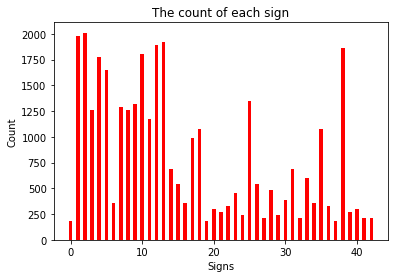

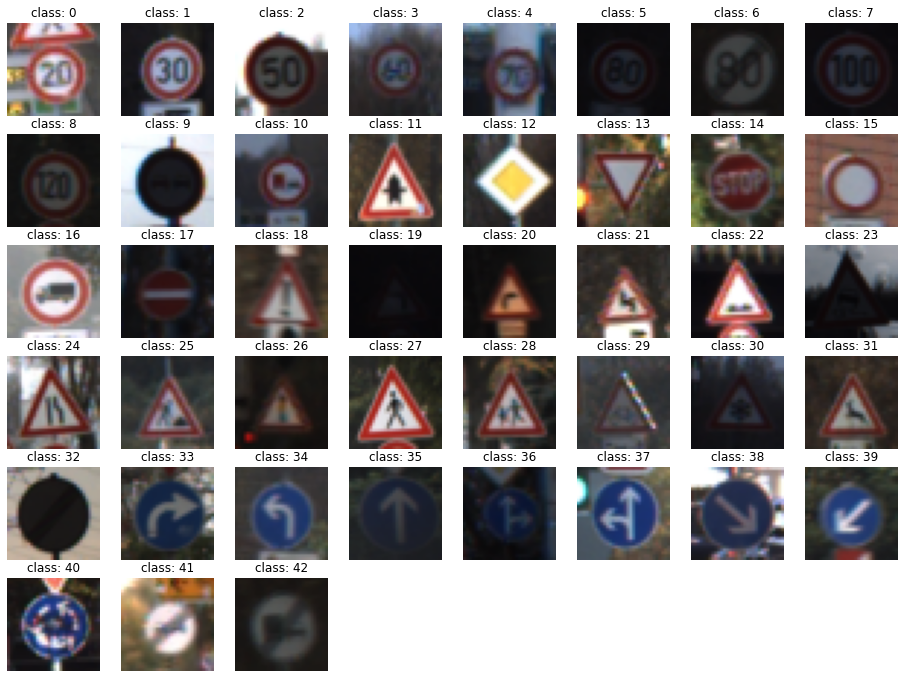

In [6]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

----

# Design and Test a Baseline Model Architecture

## Custom Dataset & DataLoader

In [7]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

In [8]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

## Baseline Model

In [9]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [10]:
torch.manual_seed(1)

In [11]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, to_device)
valid_loader = WrappedDataLoader(valid_loader, to_device)
test_loader = WrappedDataLoader(test_loader, to_device)

In [13]:
model = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
n_epochs = 20

In [14]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [15]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [16]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")

In [17]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")

In [ ]:
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.675418	Validation loss: 3.591765	 Validation accruacy: 5.601%
[Epoch 2/20] Train loss: 3.484739	Validation loss: 3.570412	 Validation accruacy: 6.259%
[Epoch 3/20] Train loss: 3.457533	Validation loss: 3.540442	 Validation accruacy: 6.168%
[Epoch 4/20] Train loss: 3.340432	Validation loss: 3.348985	 Validation accruacy: 17.143%
[Epoch 5/20] Train loss: 2.714413	Validation loss: 2.374990	 Validation accruacy: 37.098%
[Epoch 6/20] Train loss: 1.720834	Validation loss: 1.627721	 Validation accruacy: 53.991%
[Epoch 7/20] Train loss: 1.146393	Validation loss: 1.170704	 Validation accruacy: 66.735%
[Epoch 8/20] Train loss: 0.857596	Validation loss: 0.975112	 Validation accruacy: 72.608%
[Epoch 9/20] Train loss: 0.678401	Validation loss: 0.974302	 Validation accruacy: 72.404%
[Epoch 10/20] Train loss: 0.561695	Validation loss: 0.816183	 Validation accruacy: 77.710%
[Epoch 11/20] Train loss: 0.475633	Validation loss: 0.721394	 Validation accruacy: 80.023%
[Epoch 12/2

---
# Experiment and find tuning

## Data preprocessing

In [18]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

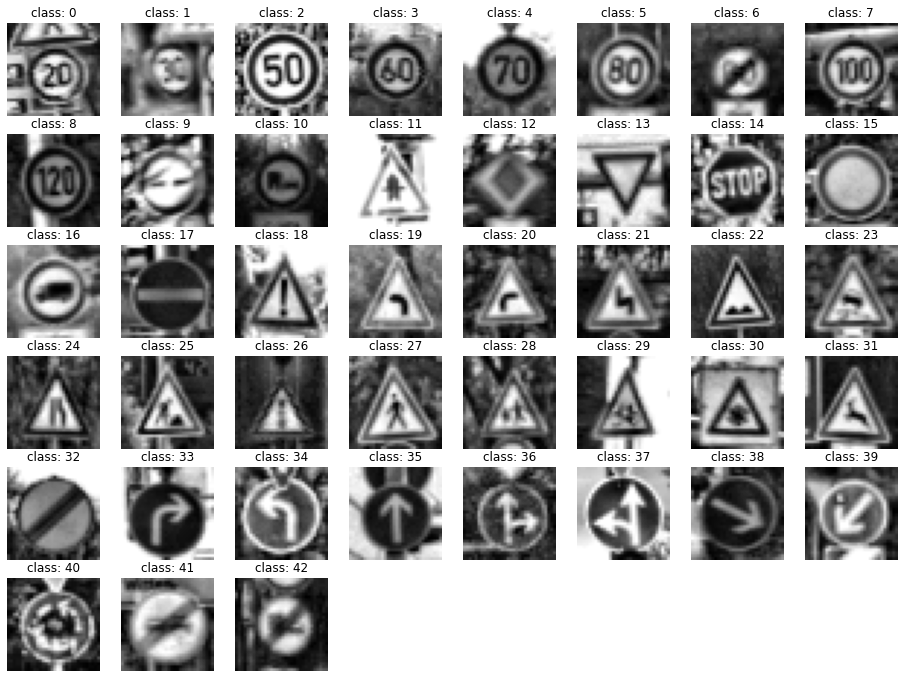

In [19]:
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [20]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [21]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.722814	Validation loss: 3.683282	 Validation accruacy: 3.401%


KeyboardInterrupt: ignored

## Save preprocessed images

In [22]:
def preprocess(path):
    if not os.path.exists(f"{path}/train_gray.p"):
        for dataset in ['train', 'valid', 'test']:
            with open(f"{path}/{dataset}.p", mode='rb') as f:
                data = pickle.load(f)
                X = data['features']
                y = data['labels']

            clahe = CLAHE_GRAY()
            for i in range(len(X)):
                X[i] = clahe(X[i])

            X = X[:, :, :, 0]
            with open(f"{path}/{dataset}_gray.p", "wb") as f:
                pickle.dump({"features": X.reshape(
                    X.shape + (1,)), "labels": y}, f)

In [23]:
preprocess('data')
training_file = 'data/train_gray.p'
validation_file = "data/valid_gray.p"
testing_file = "data/test_gray.p"

In [24]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

## Handling imbalanced dataset

### Flipping

In [25]:
def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_extended = np.empty([0] + list(dataset.features.shape)[1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype = dataset.labels.dtype)
    
    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y==c], axis=0)  
        
        if c in horizontally_flippable:
            X_extended = np.append(X_extended, X[y==c][:,:,::-1,:], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,:,:], axis=0)
        if c in cross_flippable[:,0]:
            flip_c = cross_flippable[cross_flippable[:,0]==c][0][1]
            X_extended = np.append(X_extended, X[y==flip_c][:,:,::-1,:], axis=0)
        if c in both_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,::-1,:], axis=0)
        
        y_extended = np.append(y_extended, np.full(X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))
    
    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)
    
    return dataset

In [26]:
train_dataset = extend_dataset(train_dataset)
train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)

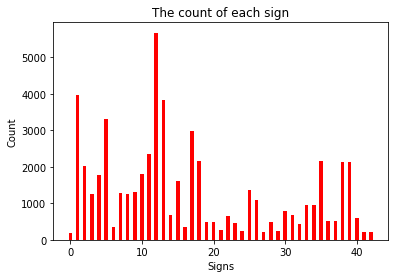

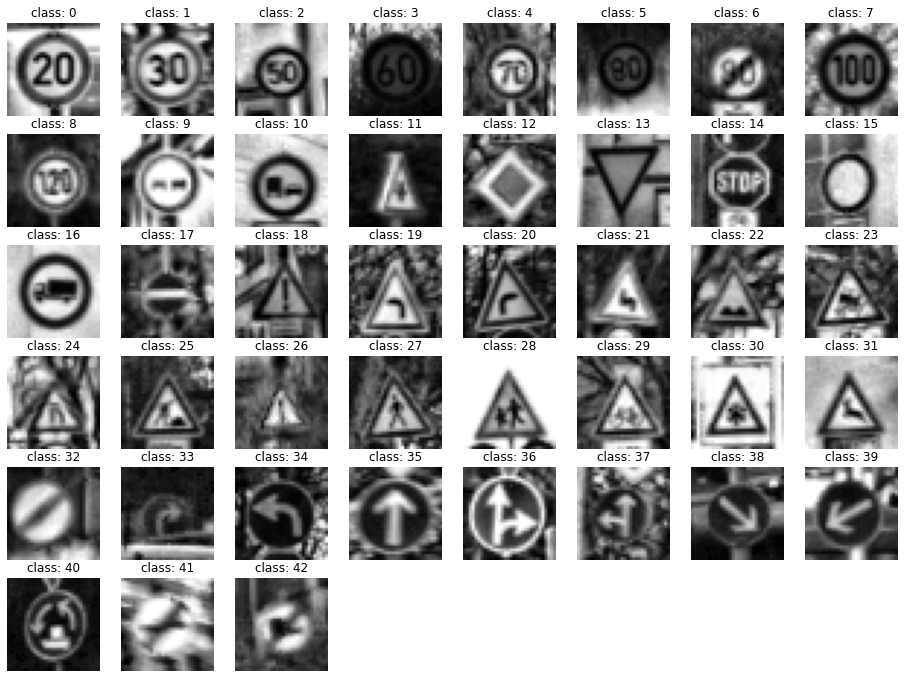

In [27]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_dataset.labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_dataset.features[i].squeeze(), cmap='gray')

In [26]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 3.617988	Validation loss: 3.646404	 Validation accruacy: 4.762%


KeyboardInterrupt: ignored

### Augmentation

In [28]:
train_dataset = extend_dataset(PickledDataset(training_file))

class_sample_count = np.bincount(train_dataset.labels)
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
samp = sampler.WeightedRandomSampler(weights, 43 * 20000)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)

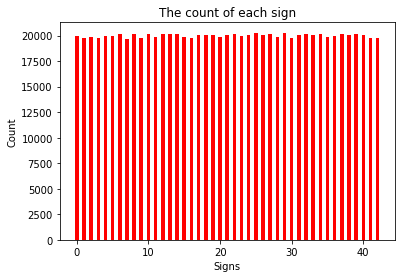

In [29]:
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_loader:
        balanced_y_train = torch.cat((balanced_y_train, y))

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

In [30]:
train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.ToTensor()

train_dataset = extend_dataset(PickledDataset(training_file, transform=train_data_transforms))
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [31]:
def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    return img

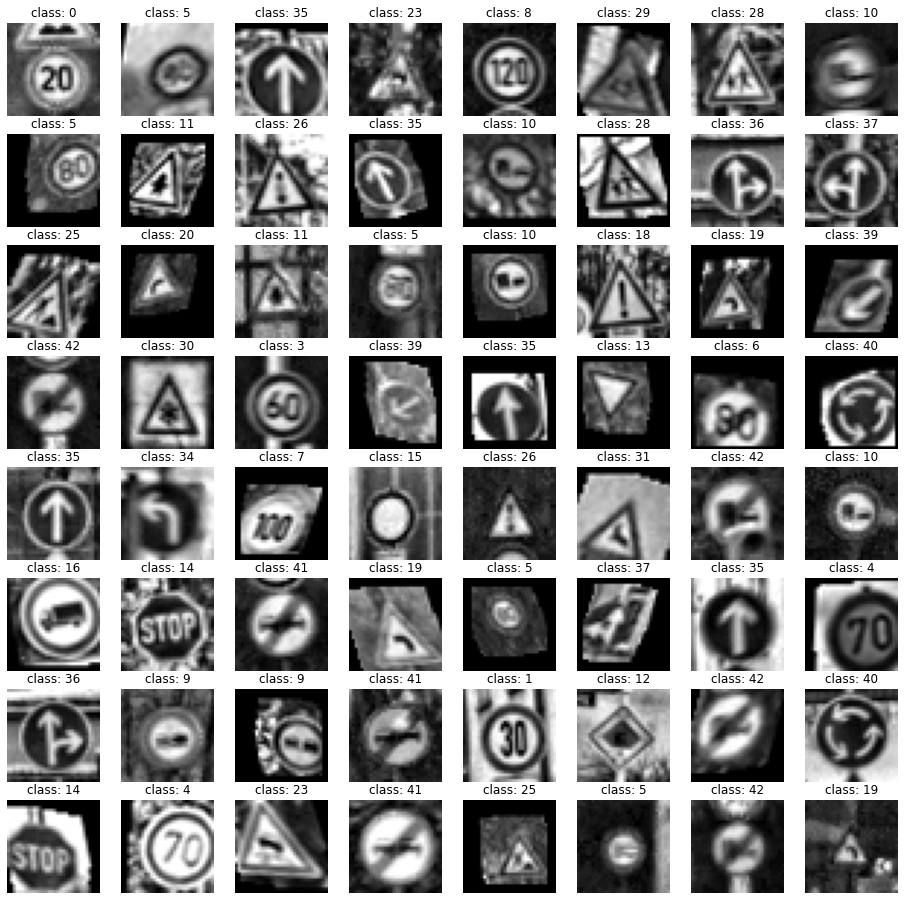

In [32]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

In [ ]:
model = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)
evaluate(model, criterion, test_loader)

[Epoch 1/20] Train loss: 2.380466	Validation loss: 0.574594	 Validation accruacy: 81.995%
[Epoch 2/20] Train loss: 0.767553	Validation loss: 0.346210	 Validation accruacy: 90.567%
[Epoch 3/20] Train loss: 0.512051	Validation loss: 0.310381	 Validation accruacy: 92.018%
[Epoch 4/20] Train loss: 0.407675	Validation loss: 0.279048	 Validation accruacy: 91.655%
[Epoch 5/20] Train loss: 0.346381	Validation loss: 0.281919	 Validation accruacy: 93.129%
[Epoch 6/20] Train loss: 0.304579	Validation loss: 0.271469	 Validation accruacy: 94.036%
[Epoch 7/20] Train loss: 0.275263	Validation loss: 0.301138	 Validation accruacy: 92.834%
[Epoch 8/20] Train loss: 0.250592	Validation loss: 0.282794	 Validation accruacy: 93.673%
[Epoch 9/20] Train loss: 0.232405	Validation loss: 0.248254	 Validation accruacy: 94.558%
[Epoch 10/20] Train loss: 0.218885	Validation loss: 0.238033	 Validation accruacy: 94.558%
[Epoch 11/20] Train loss: 0.204253	Validation loss: 0.232611	 Validation accruacy: 93.832%
[Epoch 1

## Model

In [33]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [34]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience=10):
    wait = 0
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return

In [35]:
n_epochs = 22
model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/22] Train loss: 1.177295	Validation loss: 0.167023	 Validation accruacy: 96.621%
Validation loss decreased (inf --> 0.167023). Saving model...
[Epoch 2/22] Train loss: 0.571815	Validation loss: 0.091543	 Validation accruacy: 97.687%
Validation loss decreased (0.167023 --> 0.091543). Saving model...
[Epoch 3/22] Train loss: 0.424023	Validation loss: 0.085961	 Validation accruacy: 97.823%
Validation loss decreased (0.091543 --> 0.085961). Saving model...
[Epoch 4/22] Train loss: 0.344671	Validation loss: 0.077128	 Validation accruacy: 97.937%
Validation loss decreased (0.085961 --> 0.077128). Saving model...
[Epoch 5/22] Train loss: 0.296081	Validation loss: 0.077394	 Validation accruacy: 98.118%
[Epoch 6/22] Train loss: 0.262434	Validation loss: 0.082510	 Validation accruacy: 98.299%
[Epoch 7/22] Train loss: 0.240590	Validation loss: 0.075474	 Validation accruacy: 98.345%
Validation loss decreased (0.077128 --> 0.075474). Saving model...
[Epoch 8/22] Train loss: 0.222411	Valida

In [36]:
# Saving the trained model to a particular location
torch.save(model.state_dict(), "./resources/model_withSTN.pt")

In [ ]:
check_point = torch.load('model.pt', map_location=device)
model.load_state_dict(check_point)

In [37]:

evaluate(model, criterion, test_loader)

Test loss: 0.041385	Test accruacy: 98.678%


In [38]:
# This notebook contains only the part of implementation of programming task which pertains to the model with STN (Spatial Transformer Network) Layer 
# My Code implementations for additional performance evaluation with important performance metrics for neural networks
# The following are the part of Experiment 1: 

# Getting predictions for the entire test set
with torch.no_grad():
  test_preds = torch.tensor([], device='cuda:0') # if we are using CUDA, uncomment this line and comment the following line
  #test_preds = torch.tensor([])
  for x, y in test_loader:
    test_preds = torch.cat(
      (test_preds, model(x))
      ,dim=0
    )

In [39]:
test_preds.size()

torch.Size([12630, 43])

In [41]:
# The following are the part of Experiment 1:

# Calculation of Confusion matrix
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from resources.plotcm import plot_confusion_matrix

test_preds = test_preds.cpu() # Since I am not using CUDA, I commented this line too
cm = confusion_matrix(test_loader.dl.dataset.labels, test_preds.argmax(dim=1))

Confusion matrix, without normalization


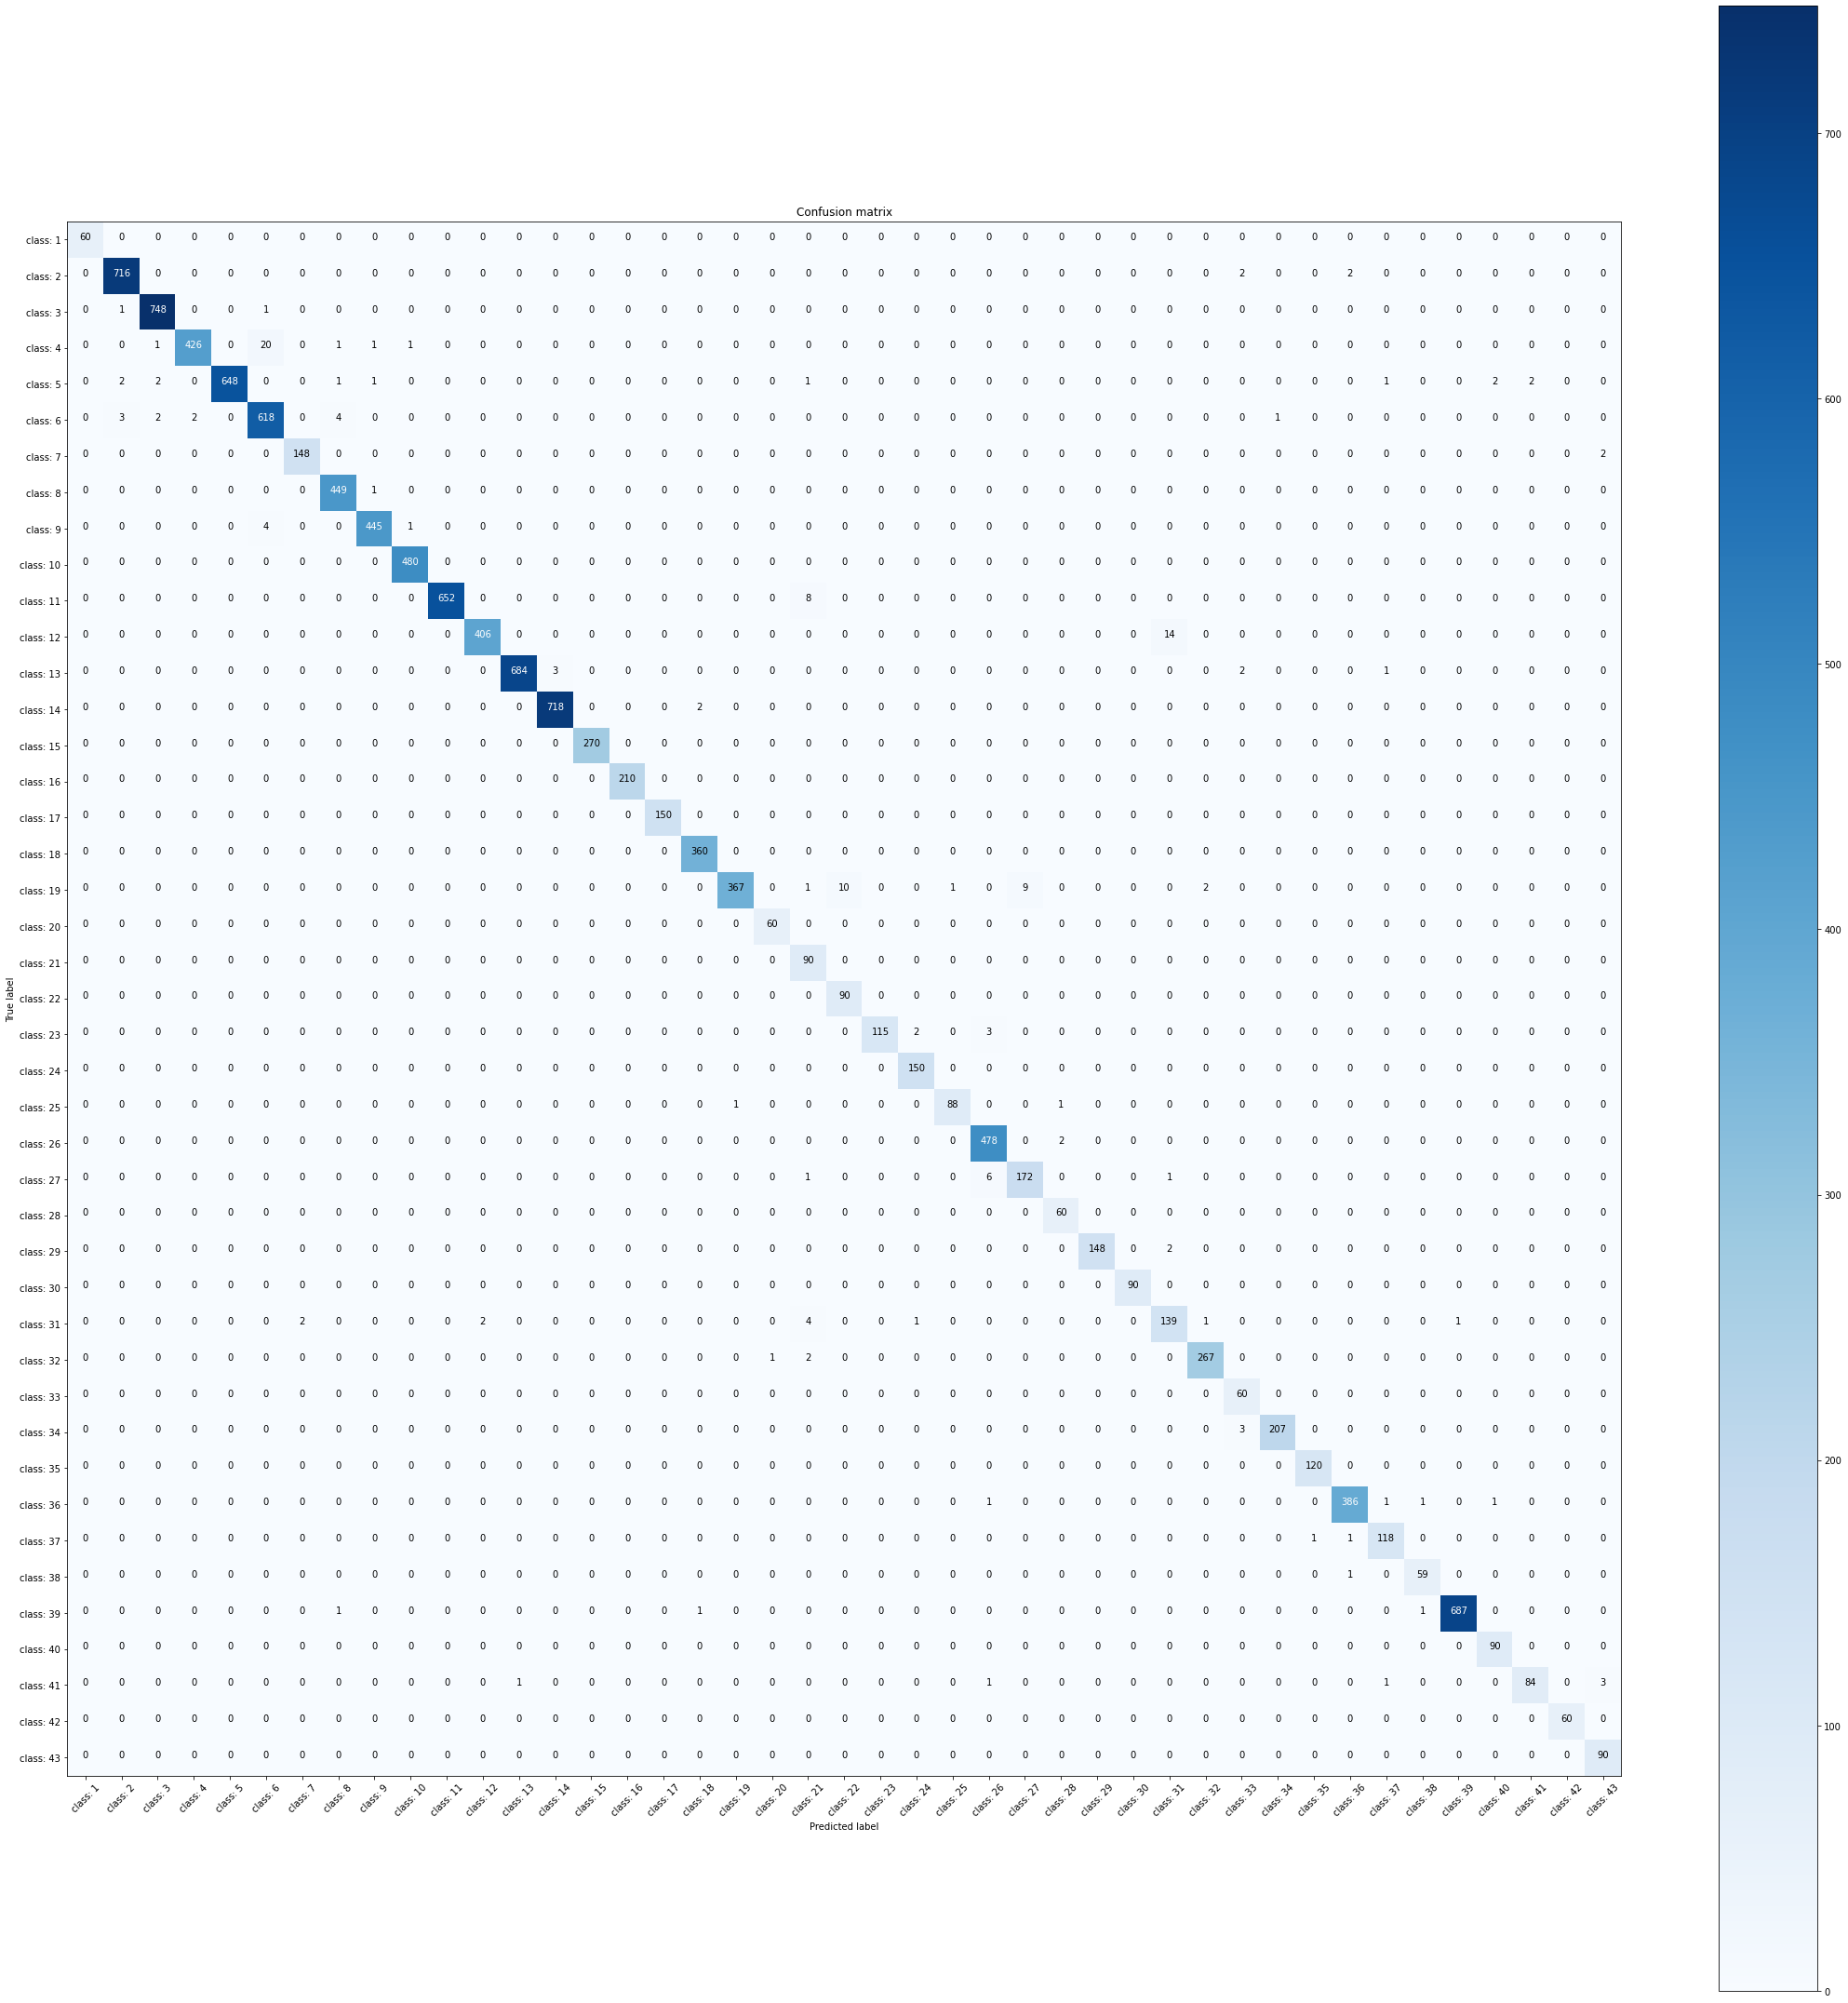

In [42]:
# The following are the part of Experiment 1:

#Plotting the Confusion matrix
class_labels = ('class: 1', 'class: 2', 'class: 3', 'class: 4', 'class: 5','class: 6','class: 7','class: 8','class: 9','class: 10','class: 11','class: 12','class: 13','class: 14','class: 15','class: 16','class: 17',
  'class: 18','class: 19','class: 20','class: 21','class: 22','class: 23','class: 24','class: 25','class: 26','class: 27','class: 28','class: 29','class: 30','class: 31','class: 32','class: 33','class: 34',
  'class: 35','class: 36','class: 37','class: 38','class: 39','class: 40','class: 41','class: 42','class: 43')
  
plt.figure(figsize=(30,30))

# upload the ./resources/plotcm.py file into the workspace before executing this line of code
plot_confusion_matrix(cm, class_labels)
plt.show()

In [43]:
# The following are the part of Experiment 1:

#Calculation of Performance metrics
accuracy_overall = np.sum(np.diag(cm))/np.sum(cm)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

recall_overall = np.mean(recall)
precision_overall = np.mean(precision)

F1_score_overall = 2 * (recall_overall * precision_overall)/(recall_overall + precision_overall)
print(f"ACCURACY : {accuracy_overall:.6f}")
print(f"RECALL : {recall_overall:.6f}")
print(f"PRECISION : {precision_overall:.6f}")
print(f"F1_SCORE : {F1_score_overall:.6f}")

ACCURACY : 0.986778
RECALL : 0.986499
PRECISION : 0.977475
F1_SCORE : 0.981967


In [44]:
# The following are the part of Experiment 3:

# As instructed in the Programming assignment, Selecting 10 images from at least 5 different classes
images = []
images_classes = []
dict = {}
for x, y in test_loader:
  if(len(images)<10):
    dict[y]= dict[y] + 1 if (y in dict) else 1
    if(dict[y] <= 2):
      images.append(x)
      images_classes.append(y)
  else: 
    break

In [45]:
# The following are the part of Experiment 3:

# Get the feature output of layer 'conv3' for each individual image and storing it in a list
model_children = list(model.children())
features_output = []
for image in images:
  result = image
  layer_index = 0
  for child in model_children:
    layer_index += 1
    if layer_index < 7:
      result = child (result)
  features_output.append(result) 

torch.Size([250, 12, 12])
Saving conv3 layer's output of image 0 (feature maps)...


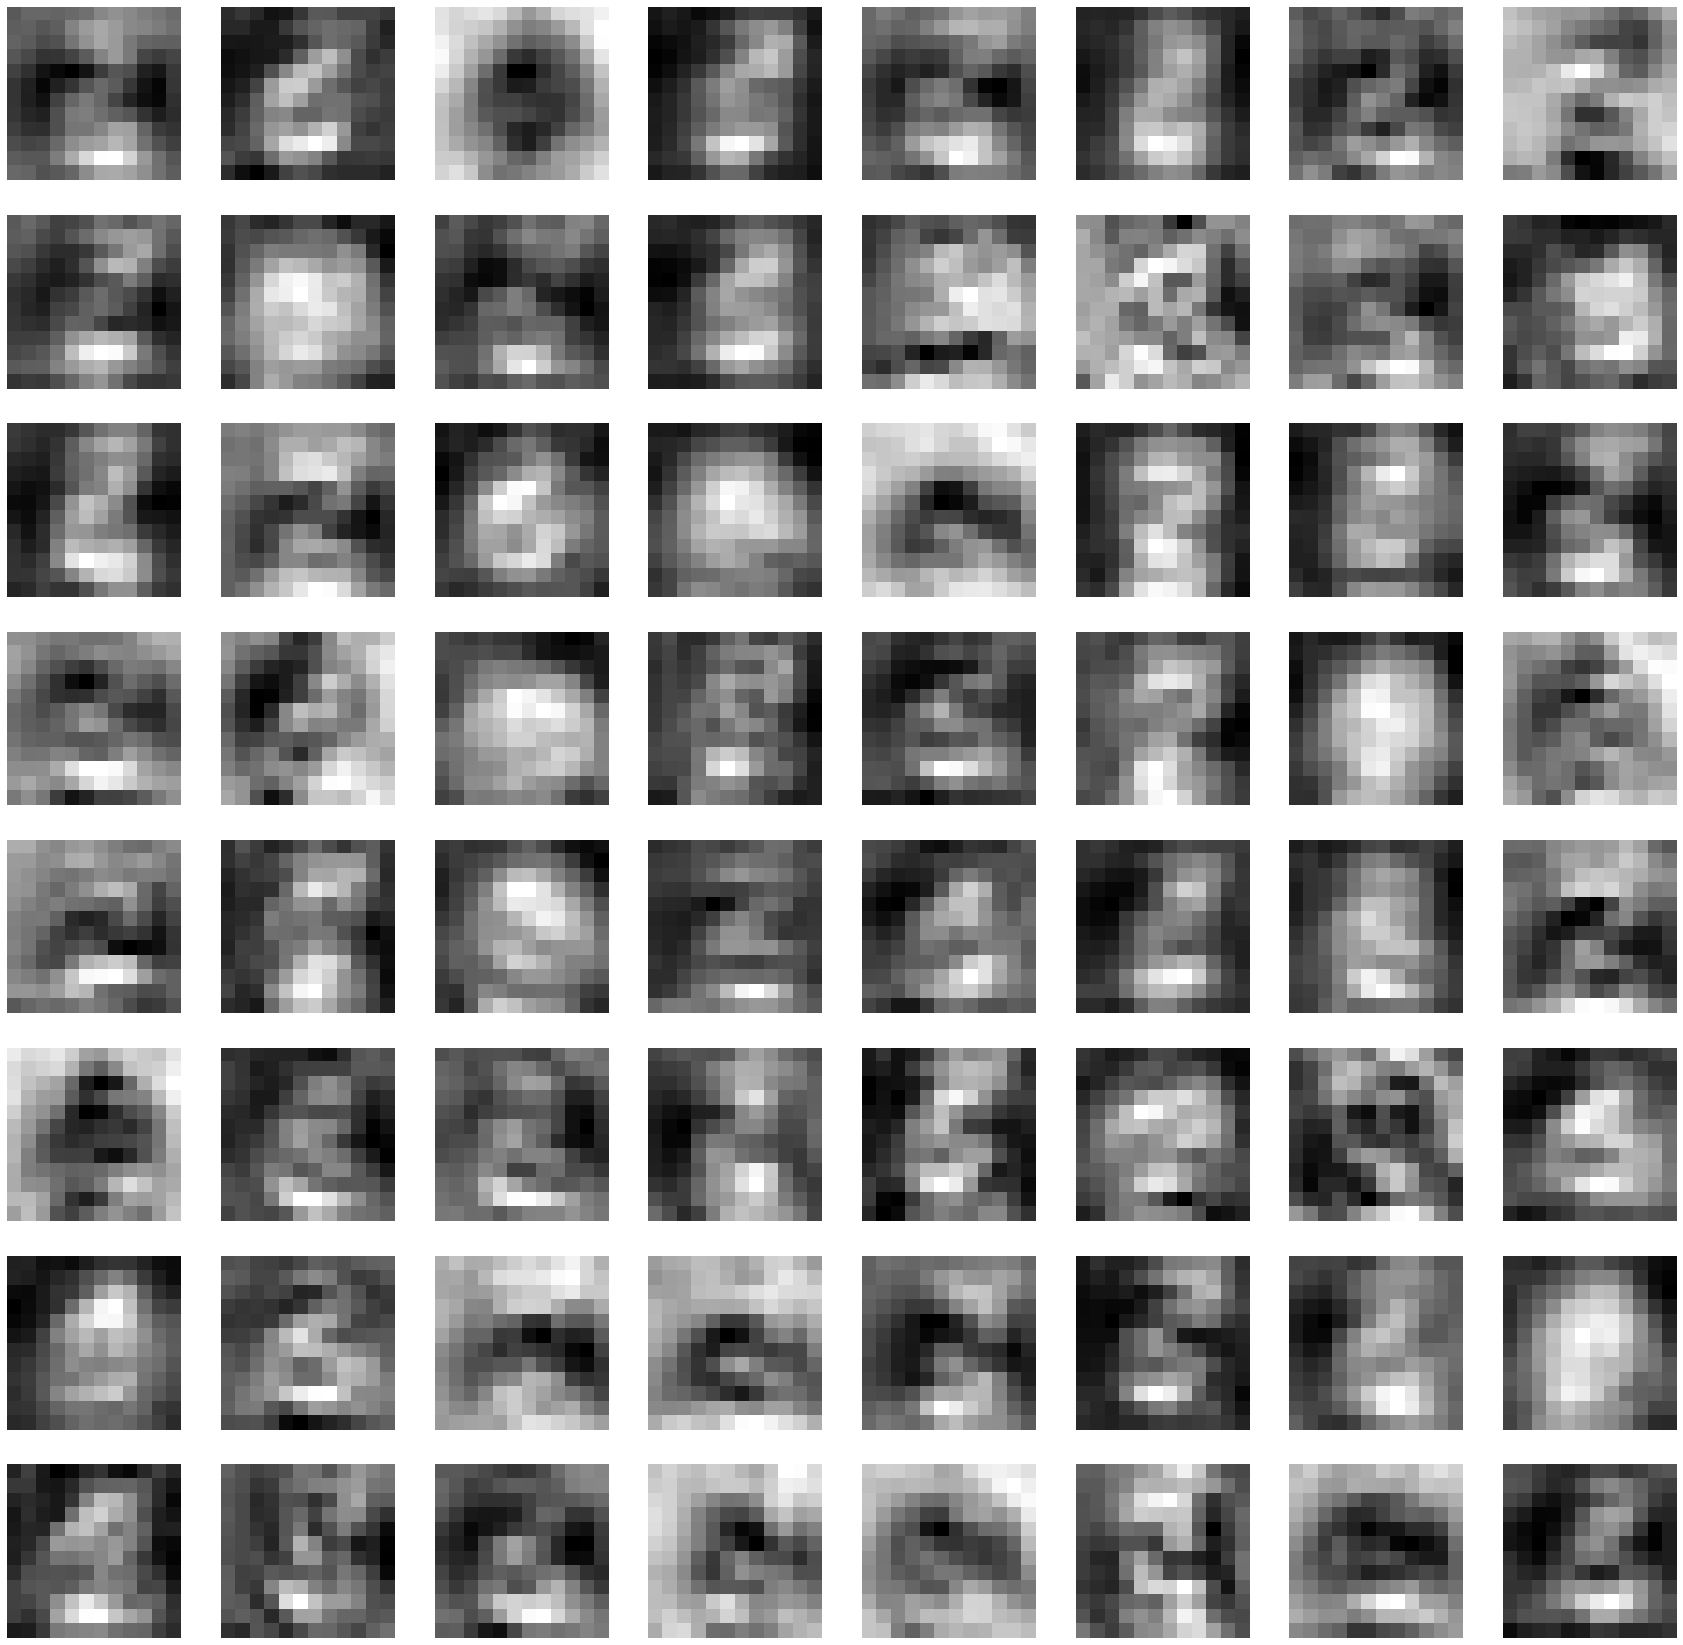

torch.Size([250, 12, 12])
Saving conv3 layer's output of image 1 (feature maps)...


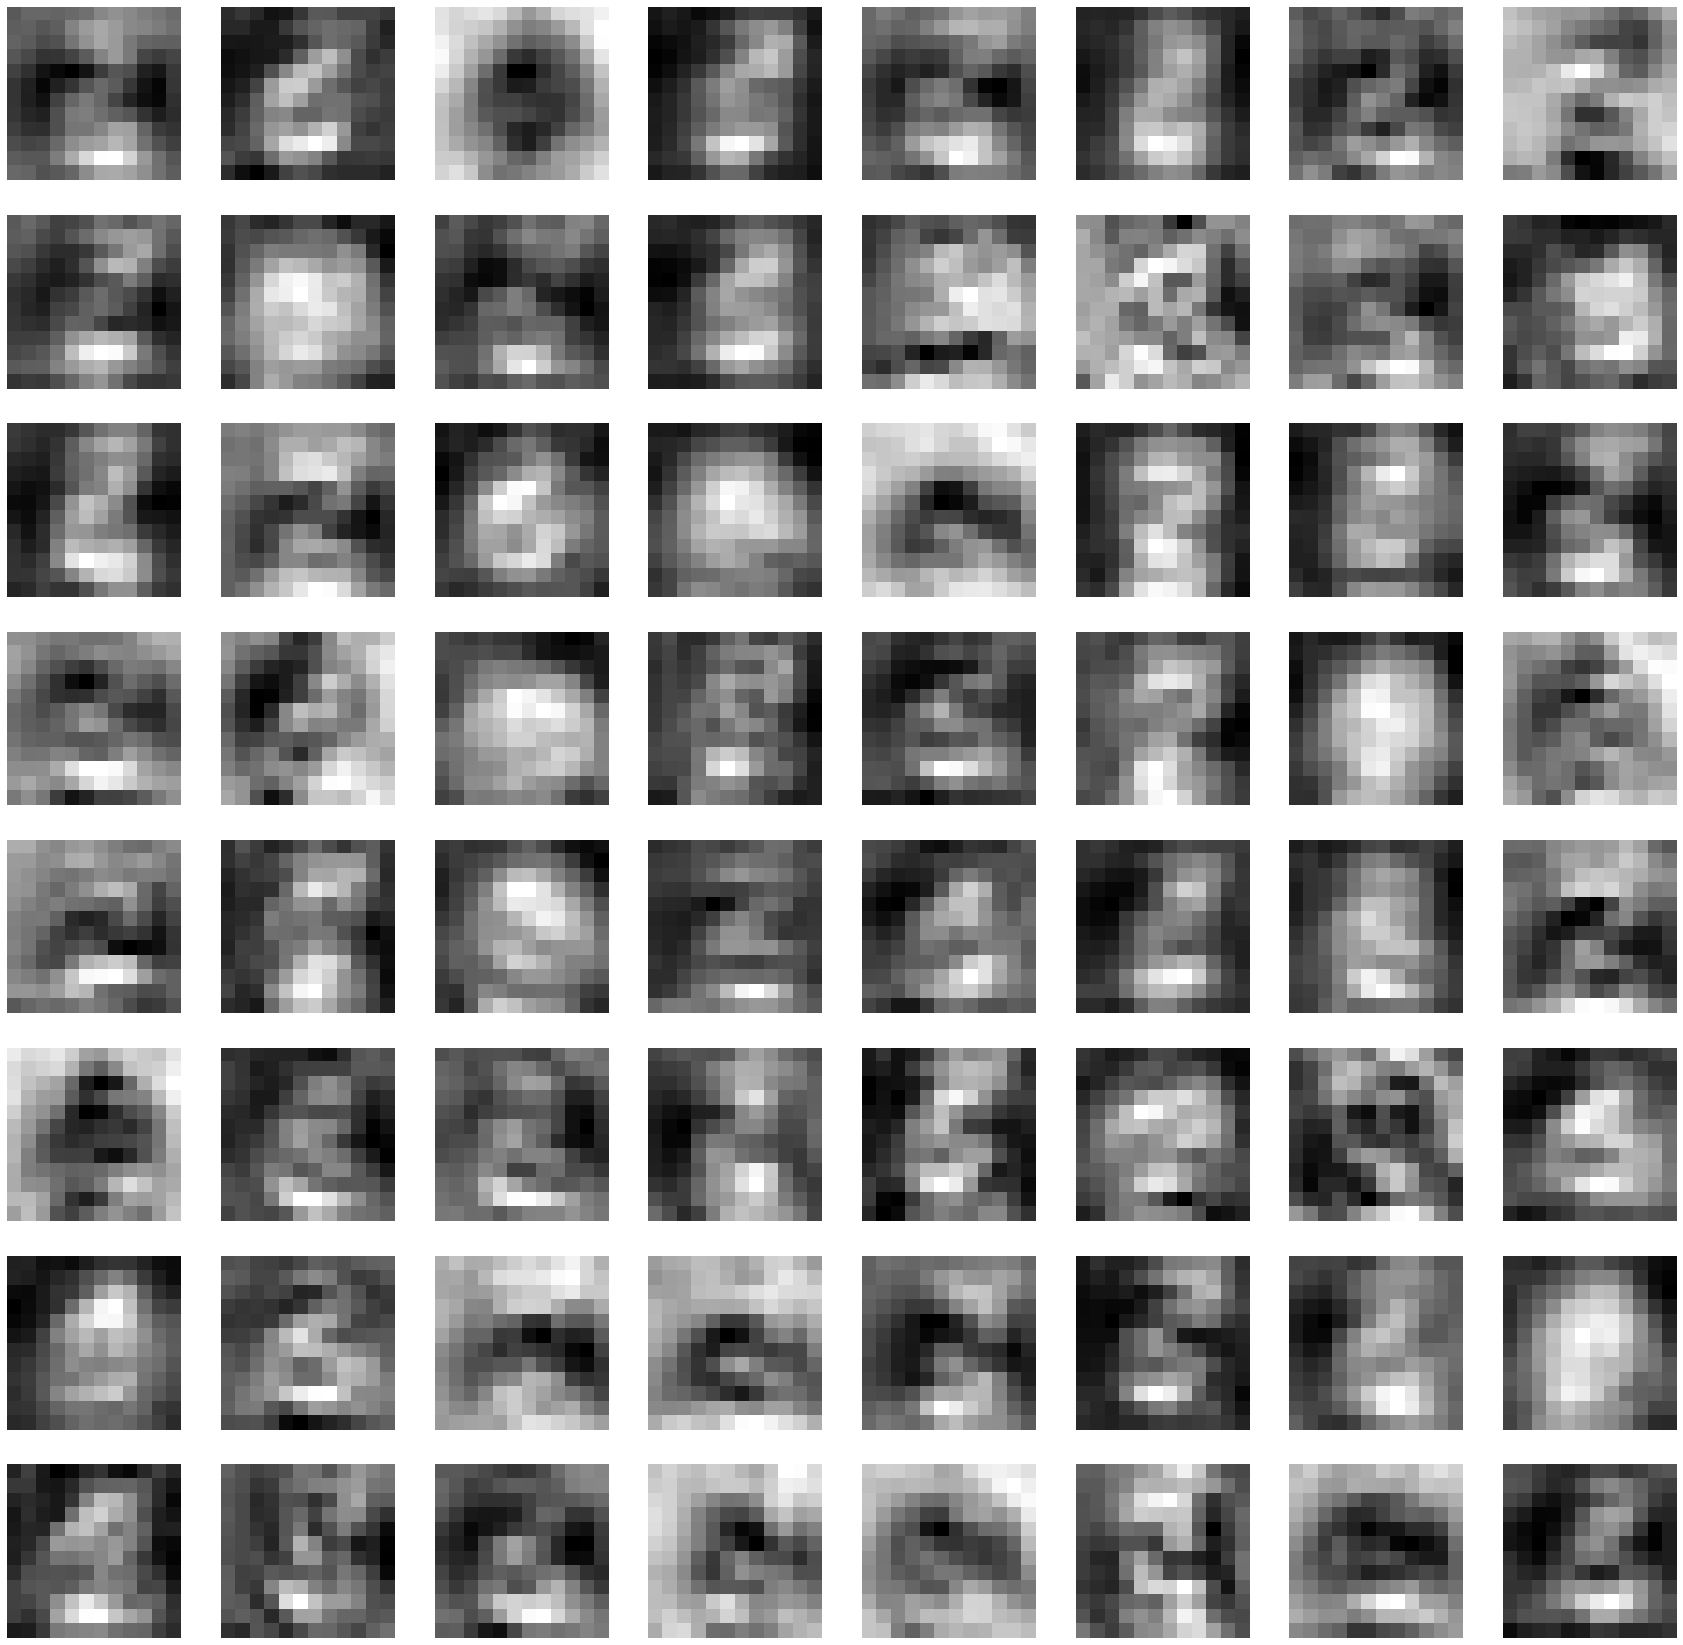

torch.Size([250, 12, 12])
Saving conv3 layer's output of image 2 (feature maps)...


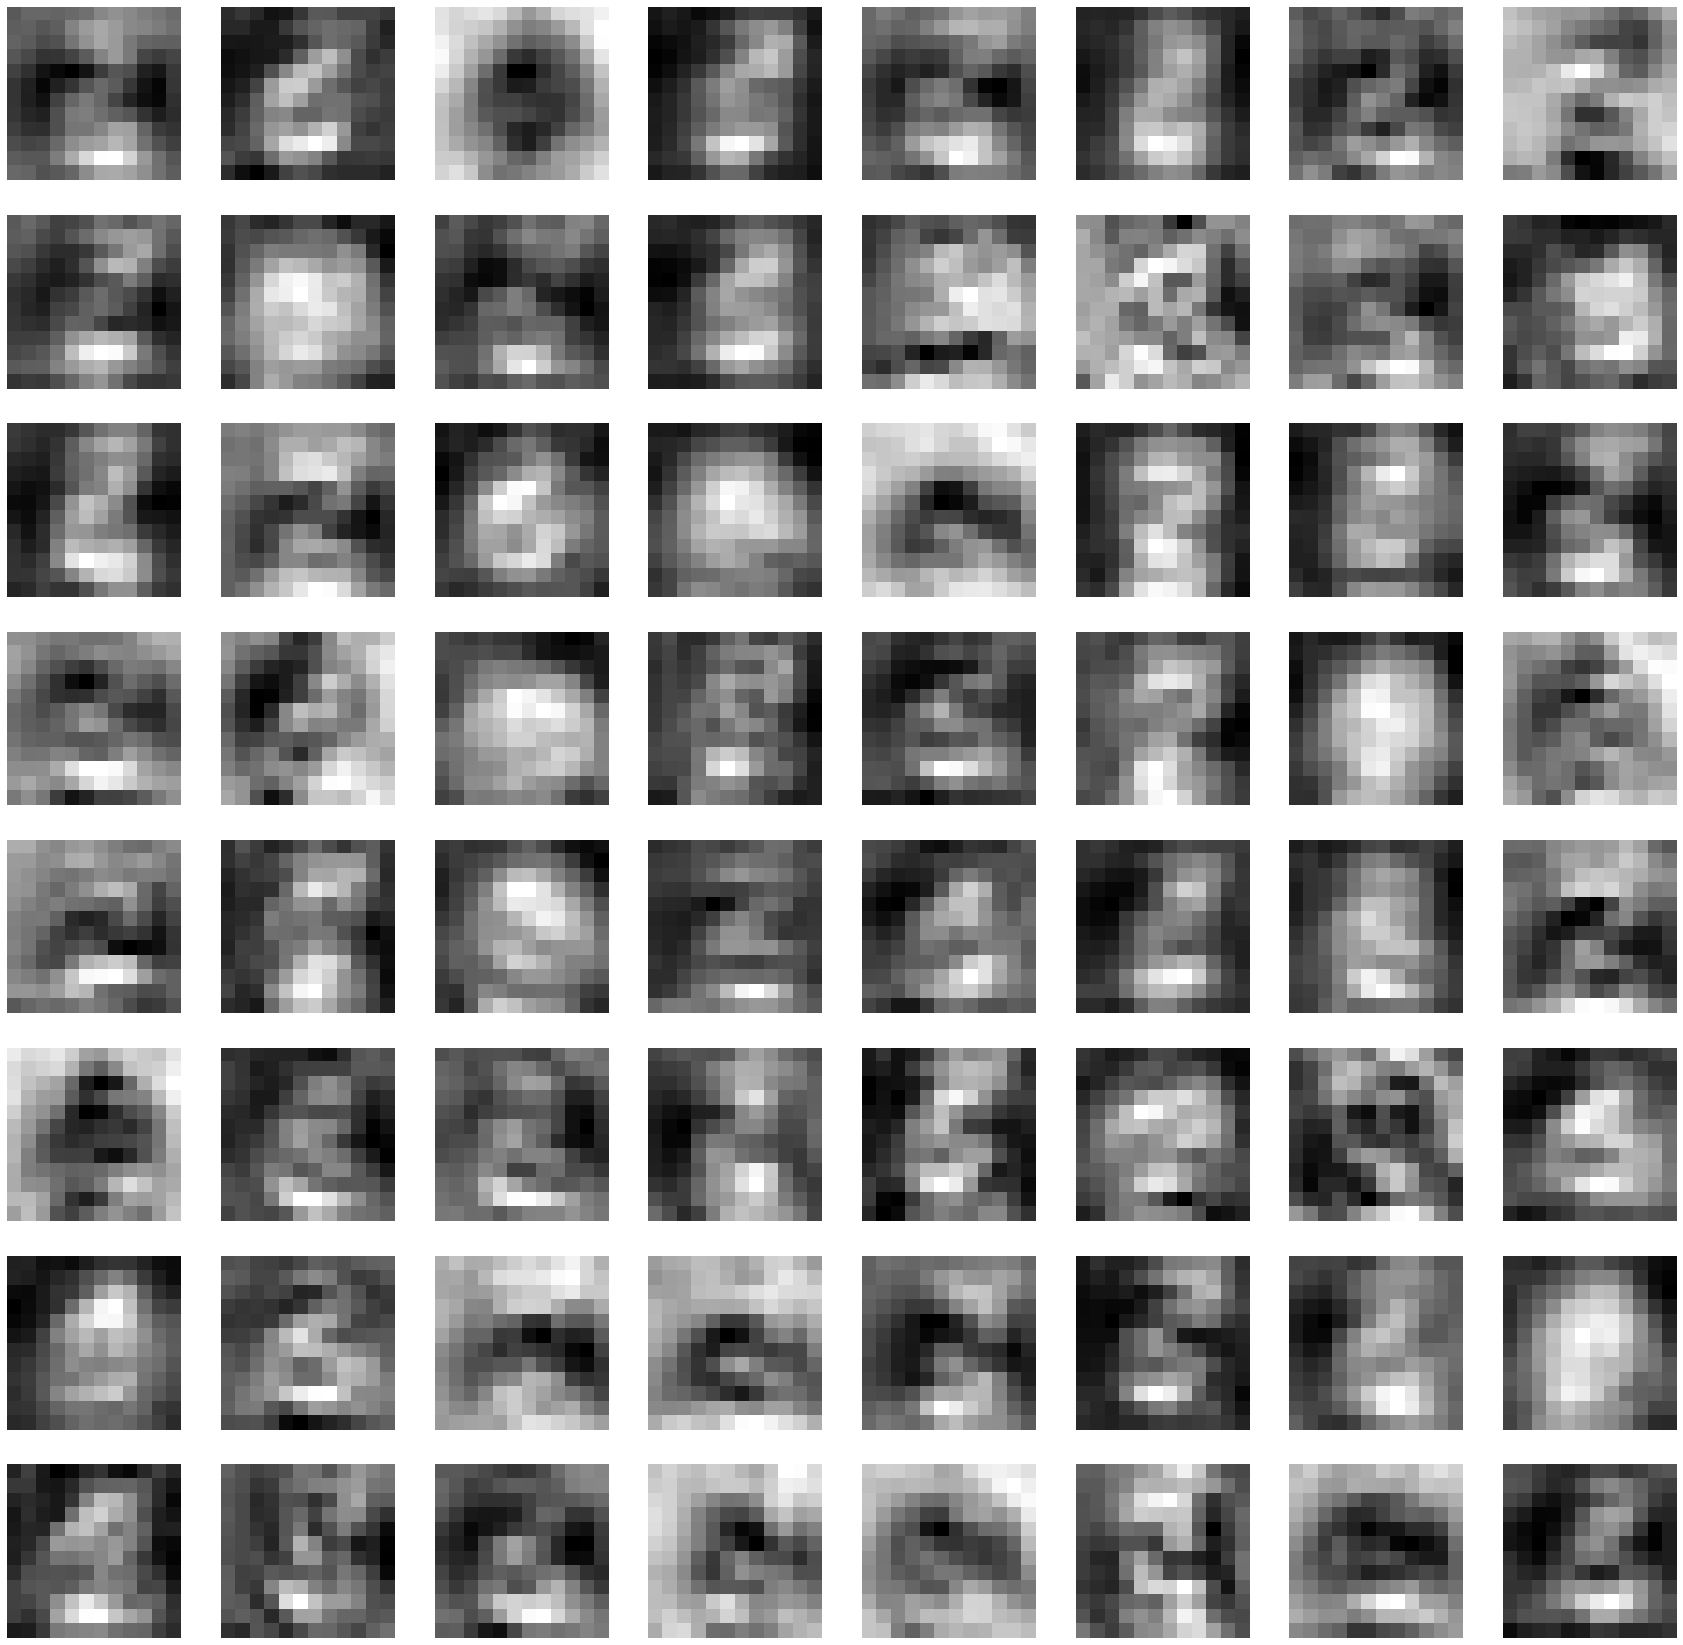

torch.Size([250, 12, 12])
Saving conv3 layer's output of image 3 (feature maps)...


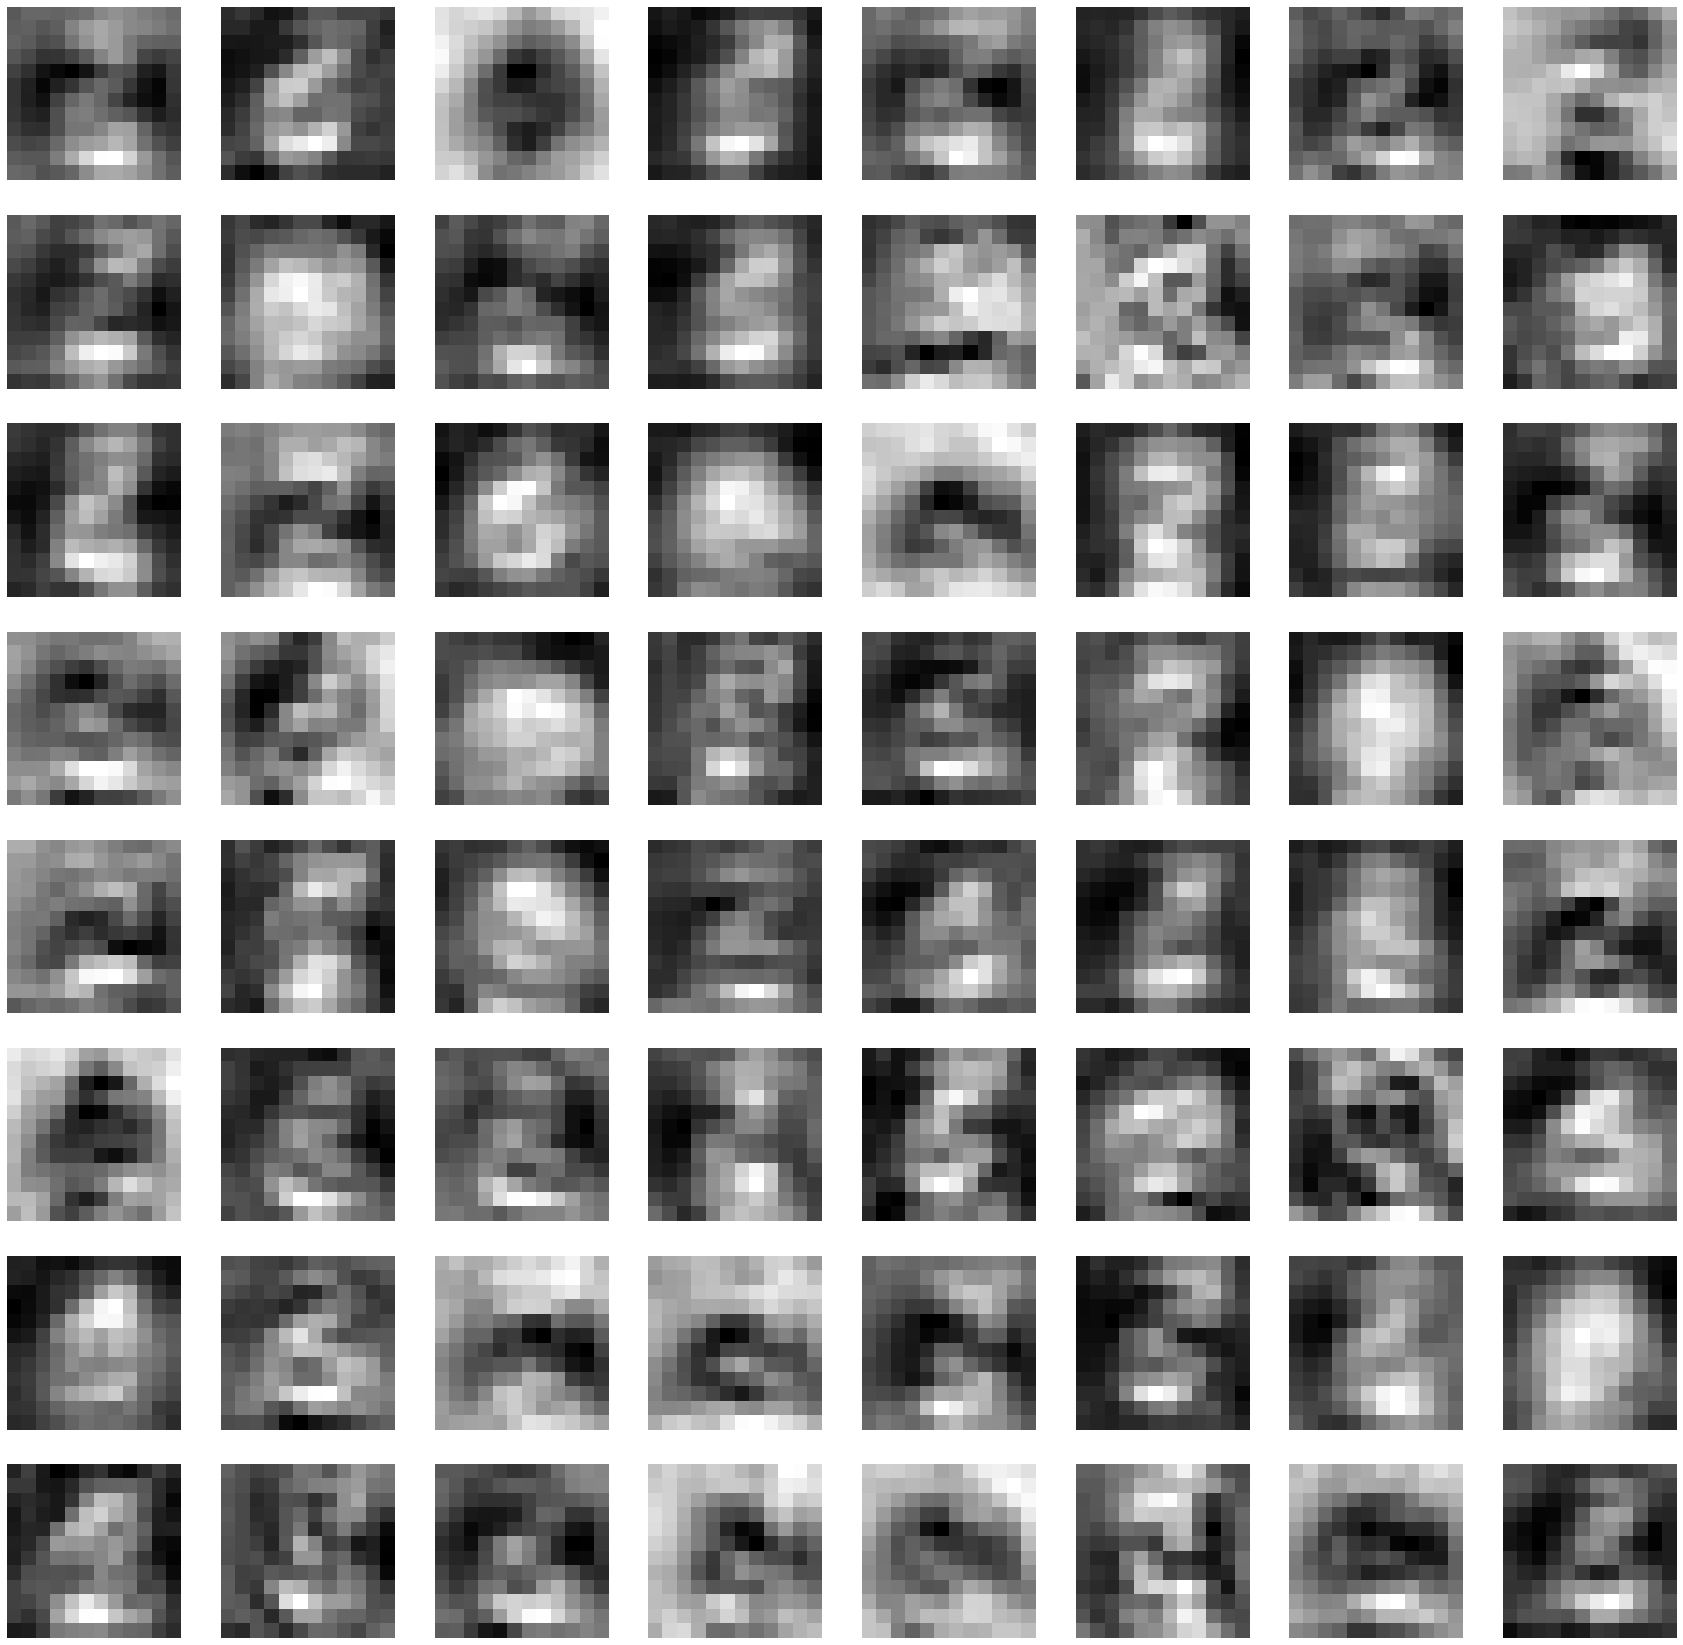

torch.Size([250, 12, 12])
Saving conv3 layer's output of image 4 (feature maps)...


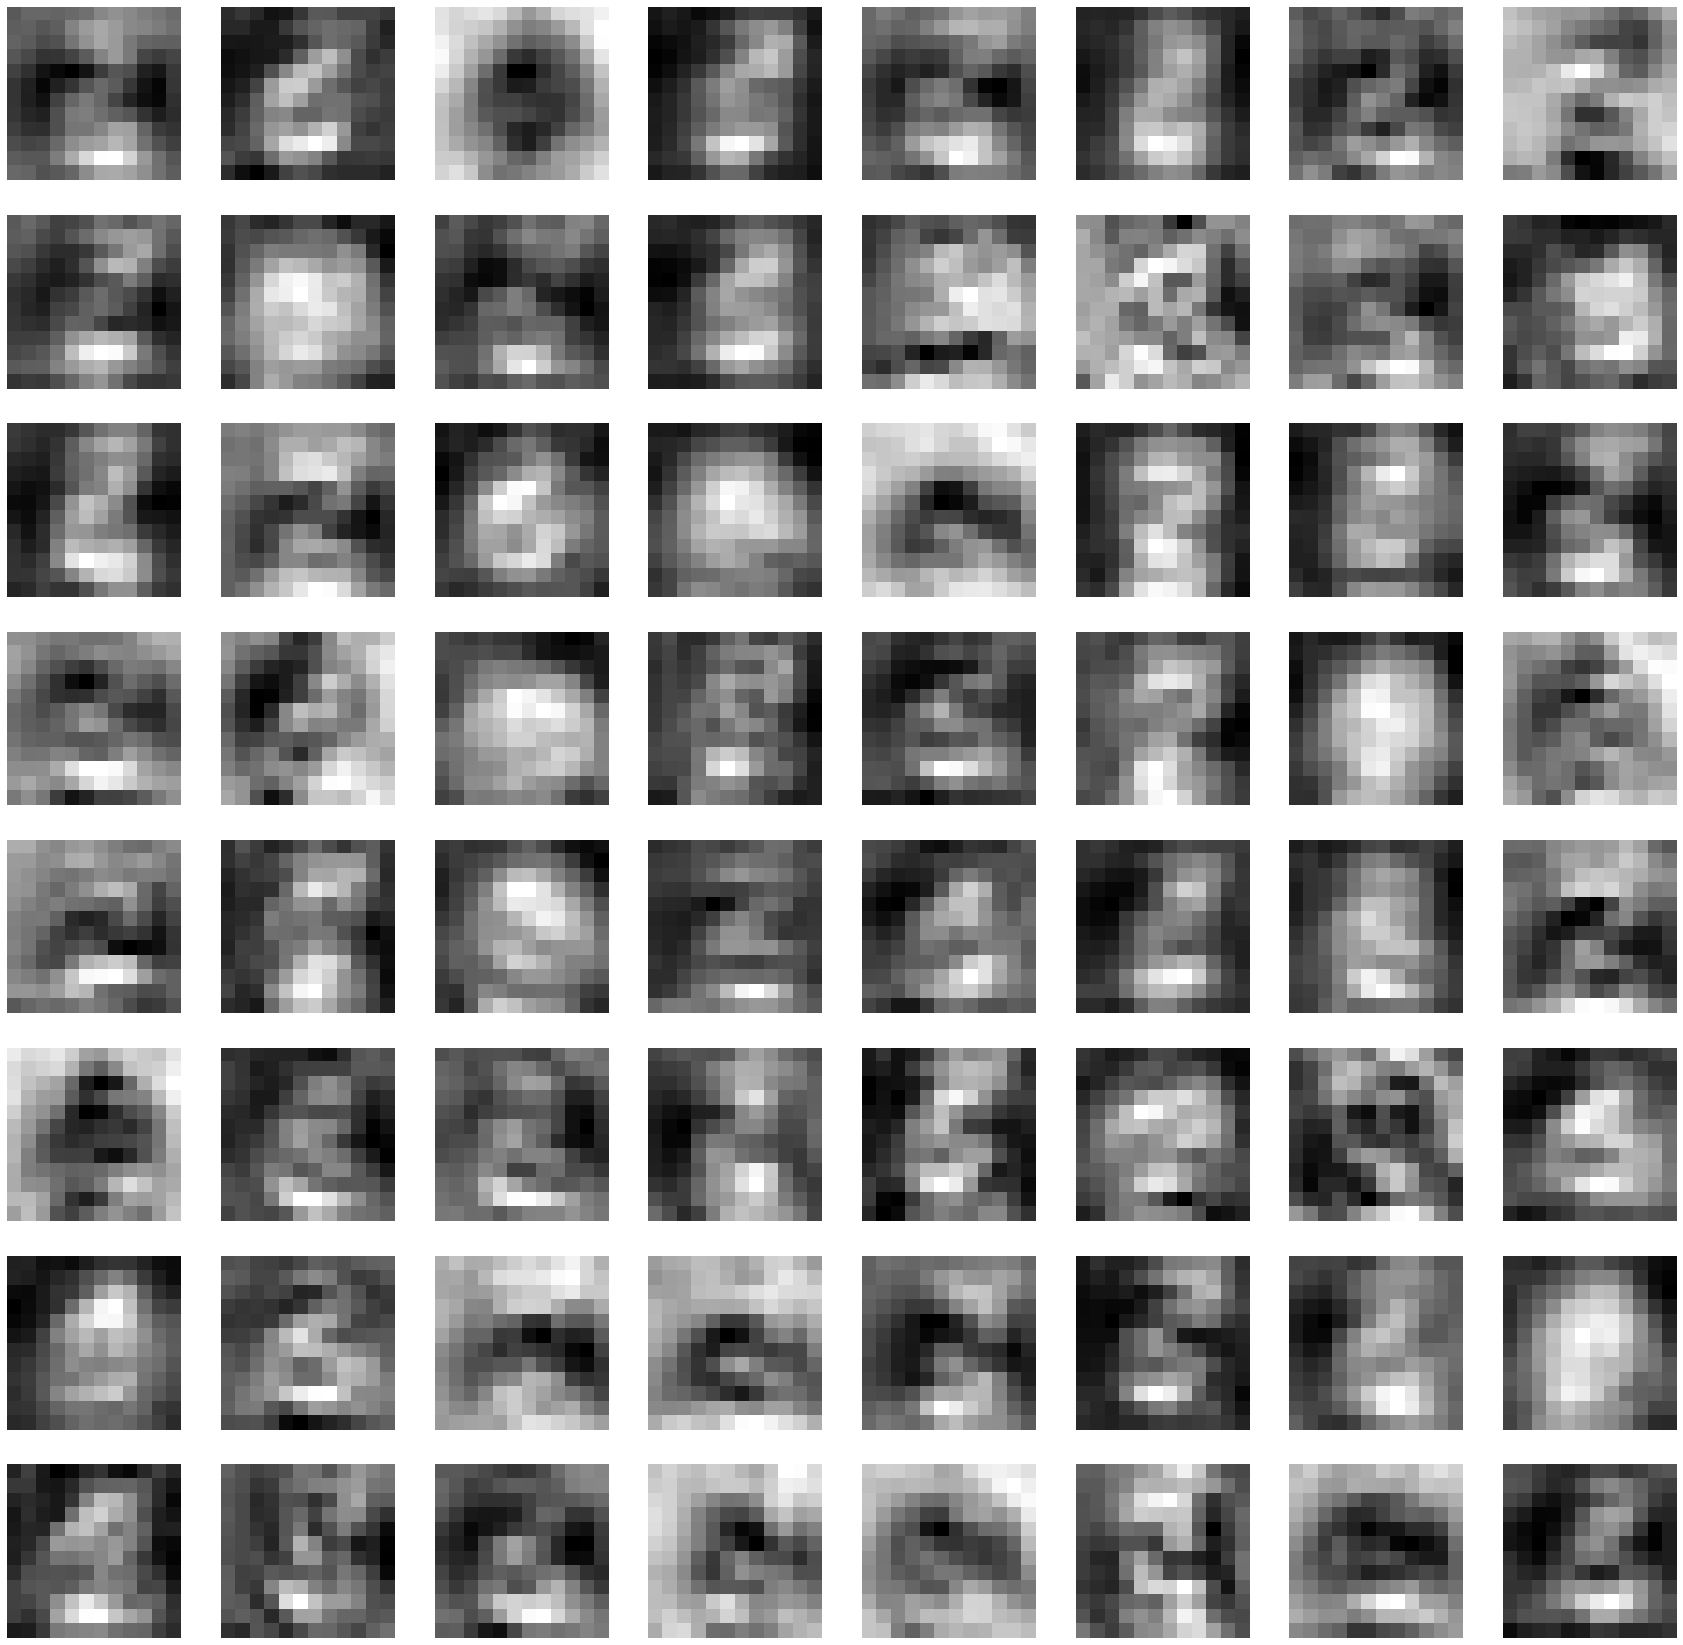

torch.Size([250, 12, 12])
Saving conv3 layer's output of image 5 (feature maps)...


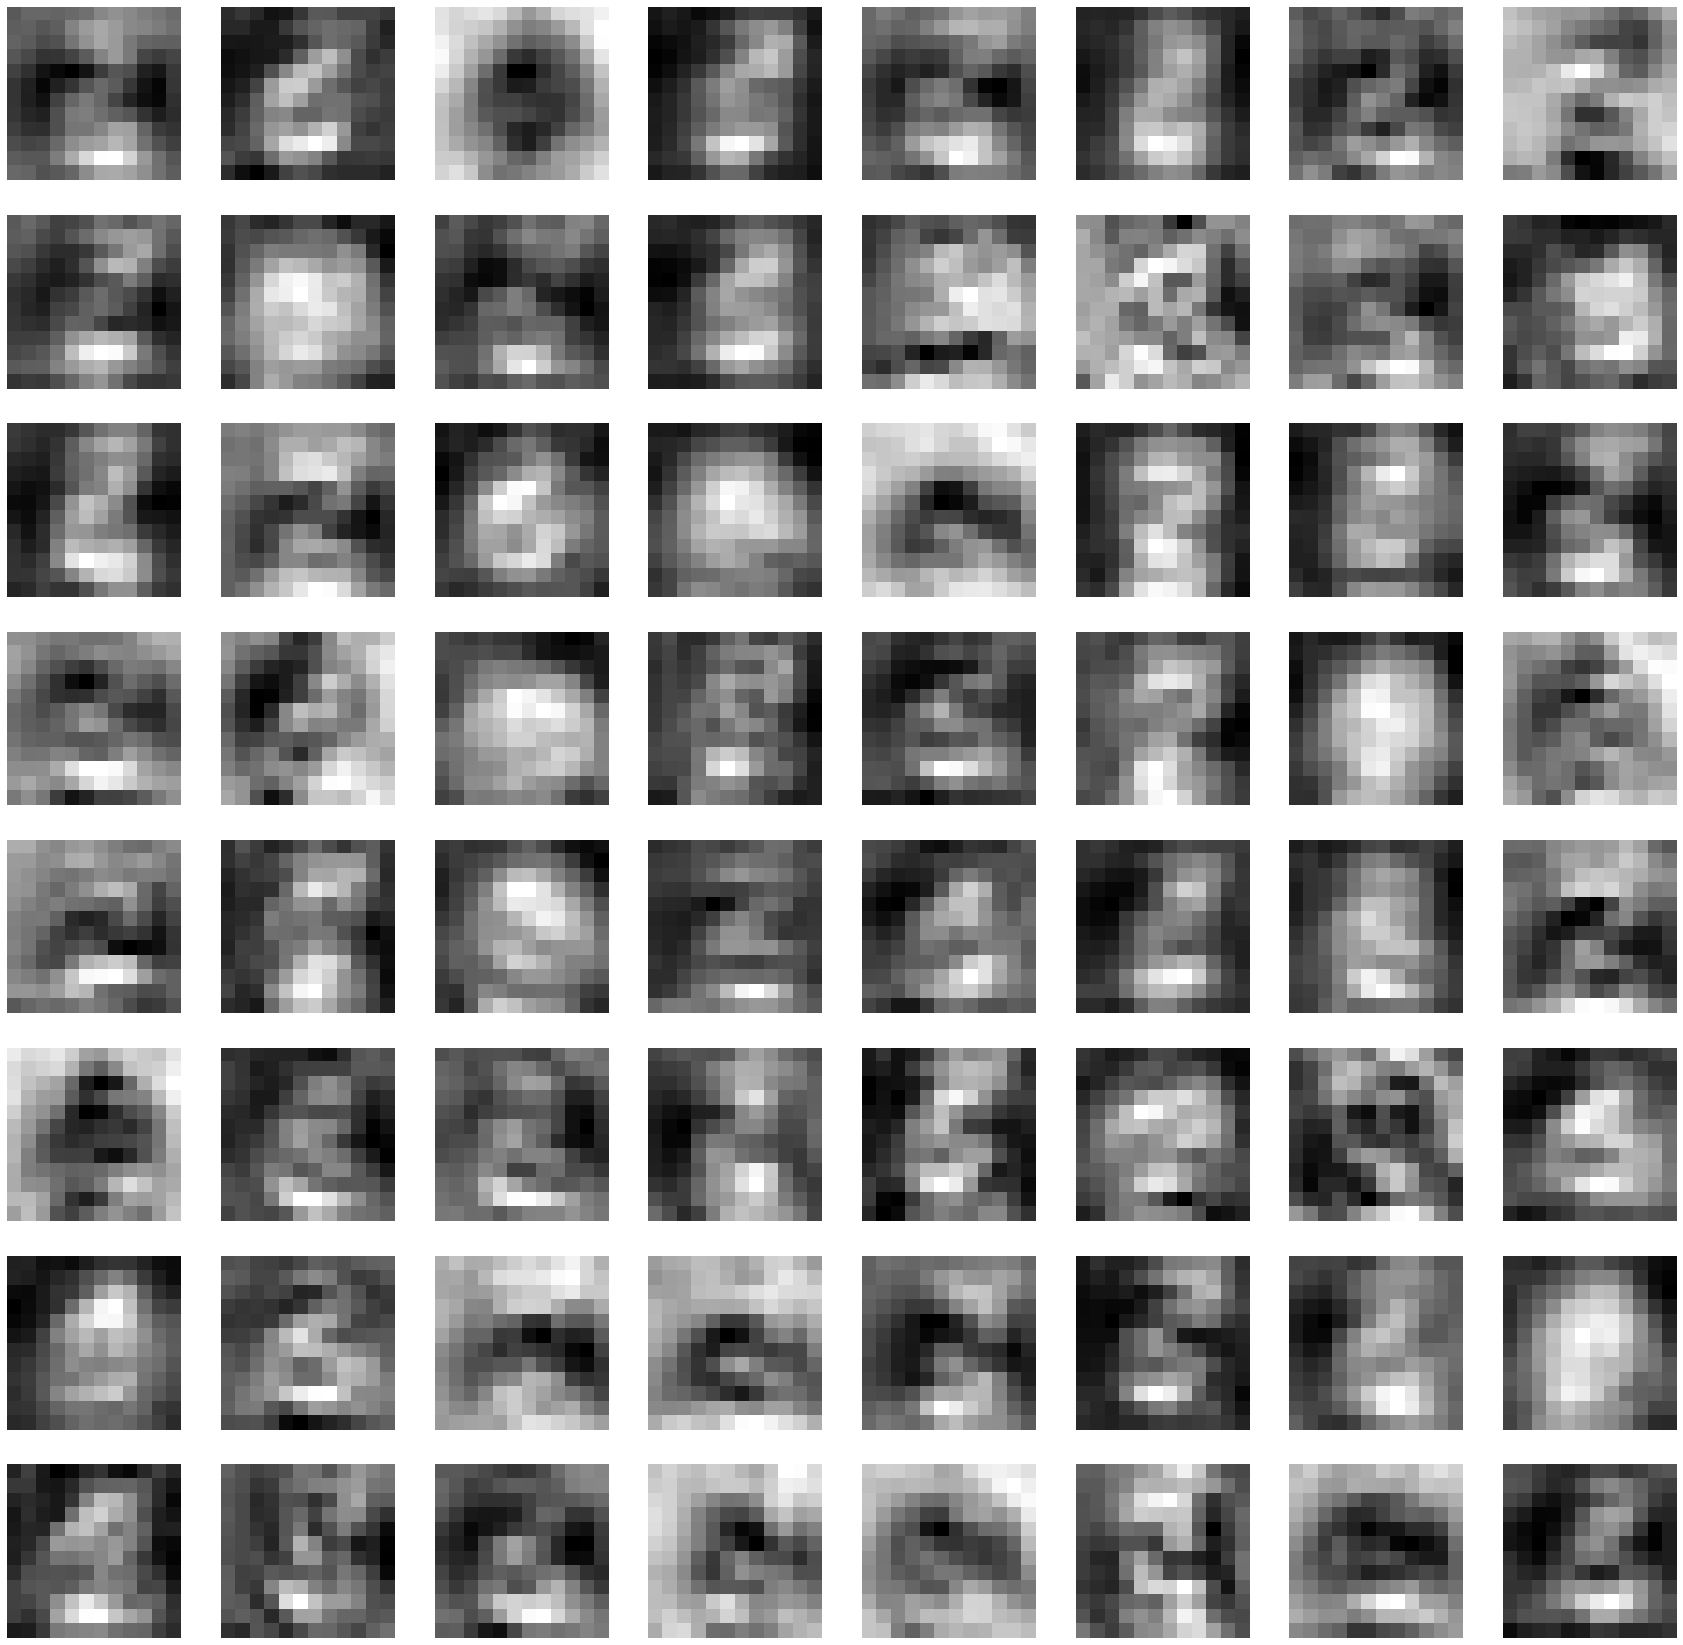

torch.Size([250, 12, 12])
Saving conv3 layer's output of image 6 (feature maps)...


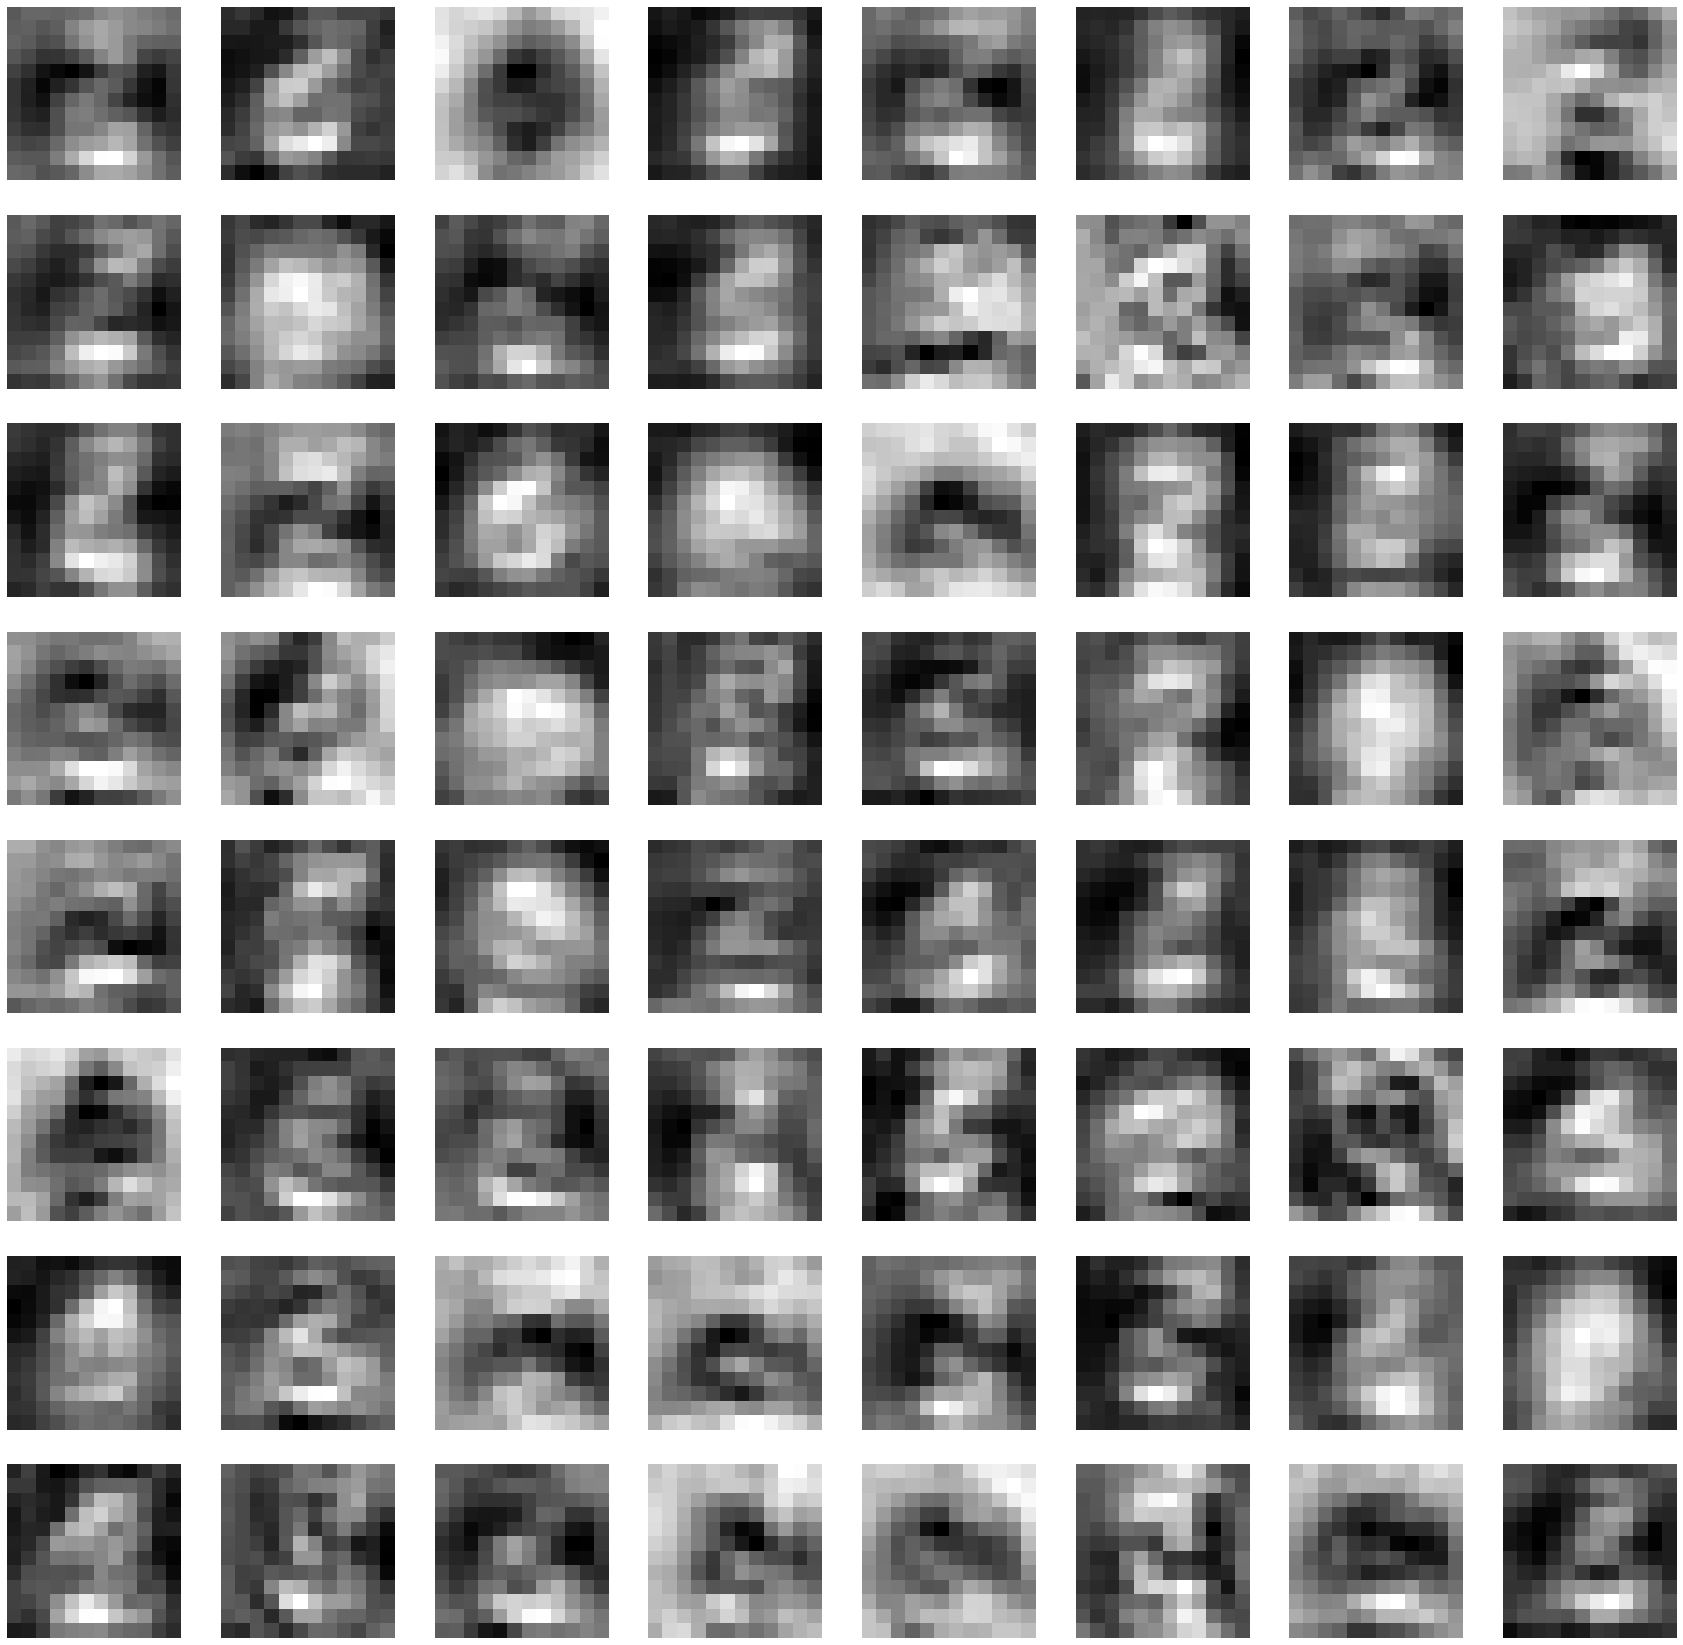

torch.Size([250, 12, 12])
Saving conv3 layer's output of image 7 (feature maps)...


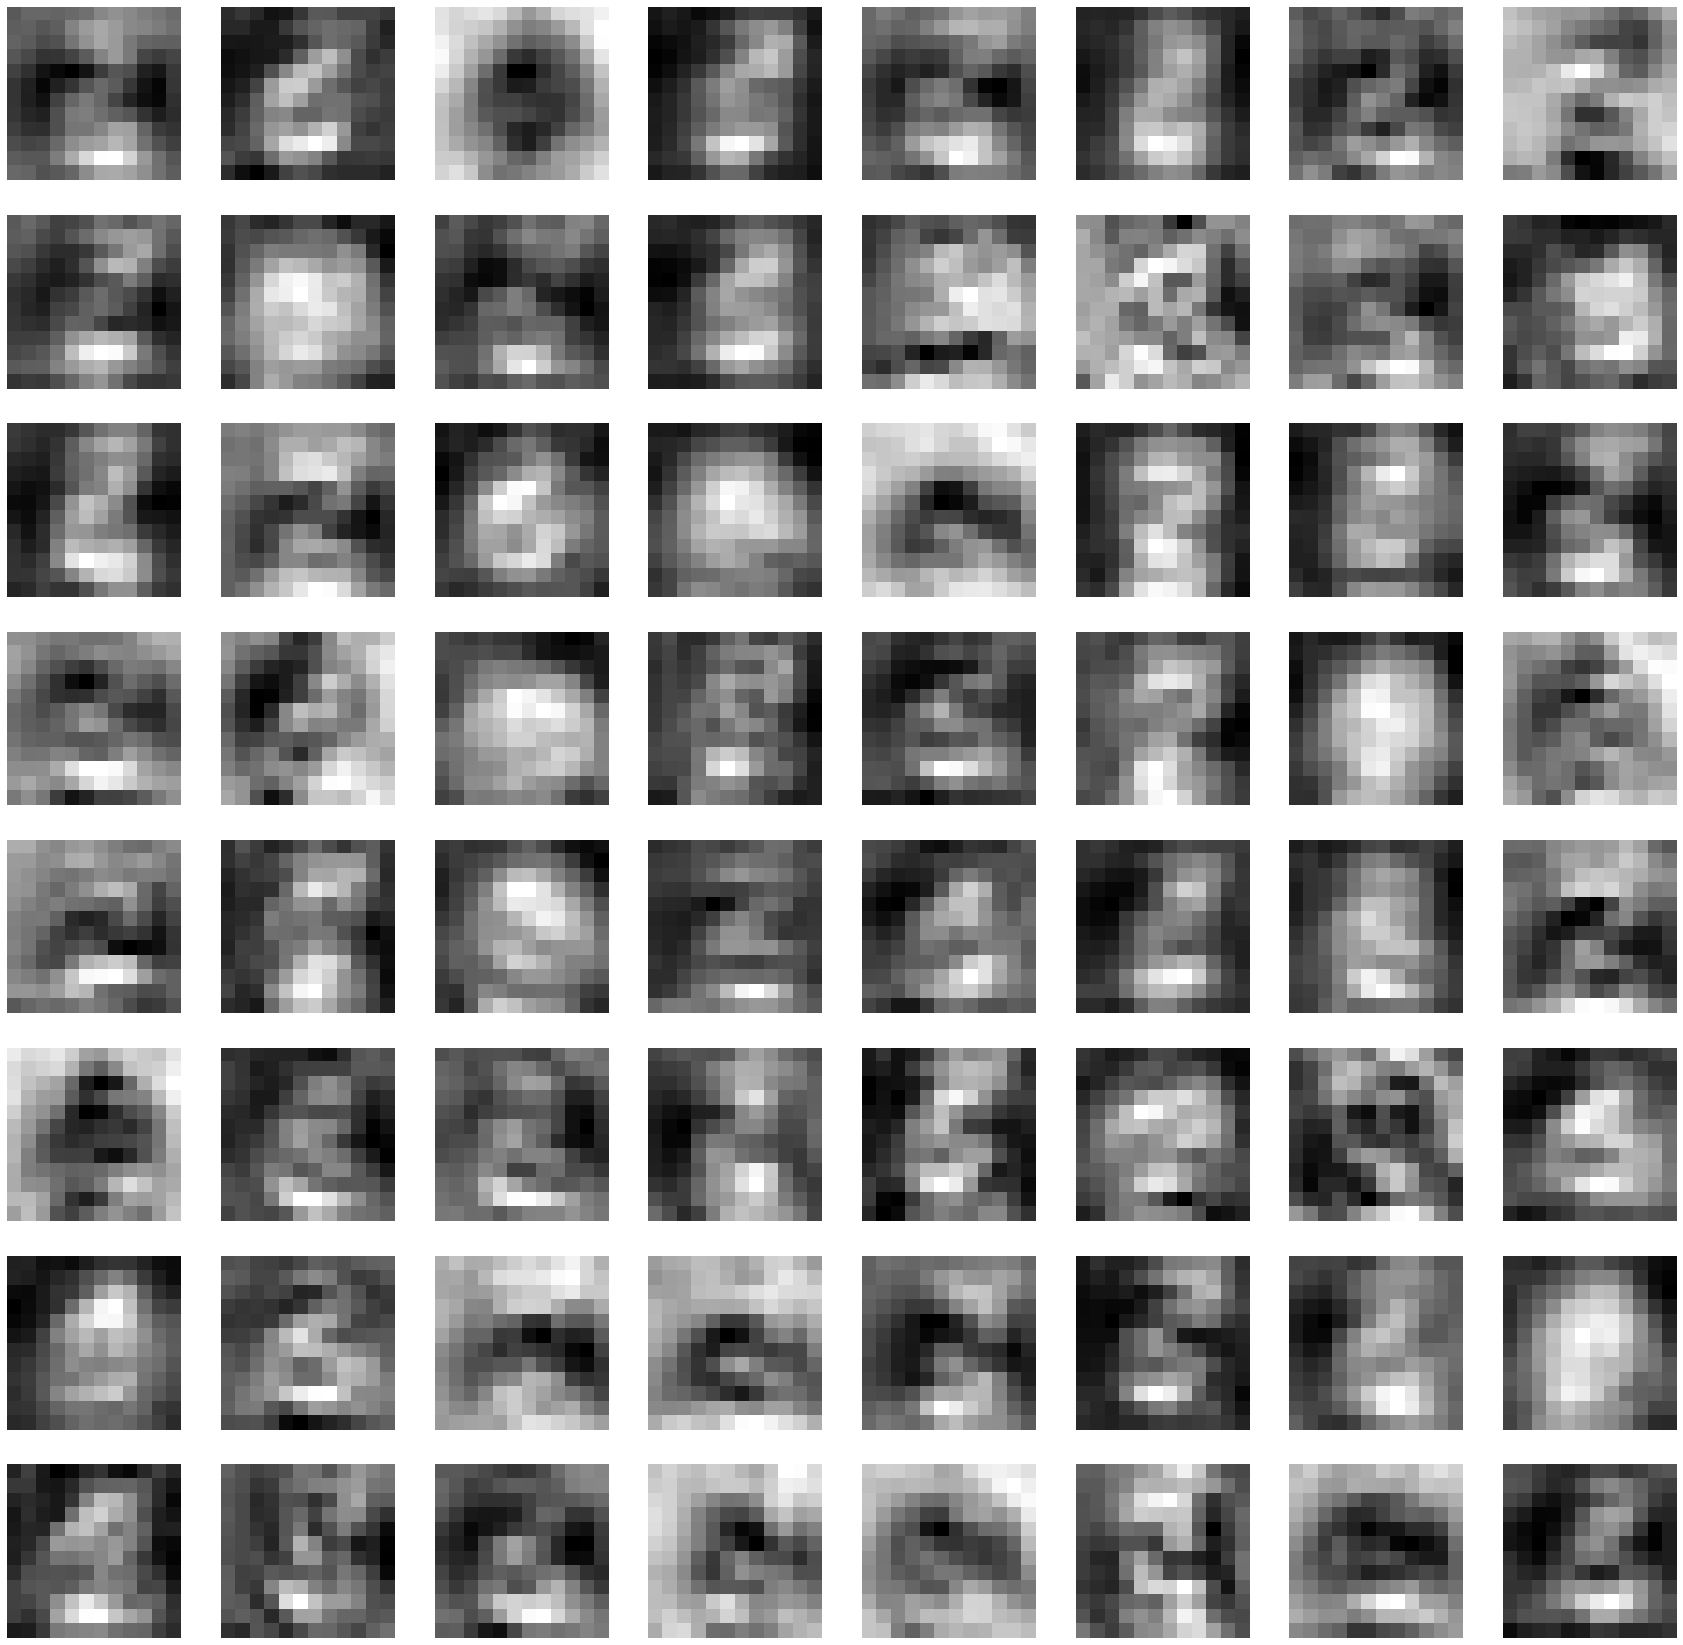

torch.Size([250, 12, 12])
Saving conv3 layer's output of image 8 (feature maps)...


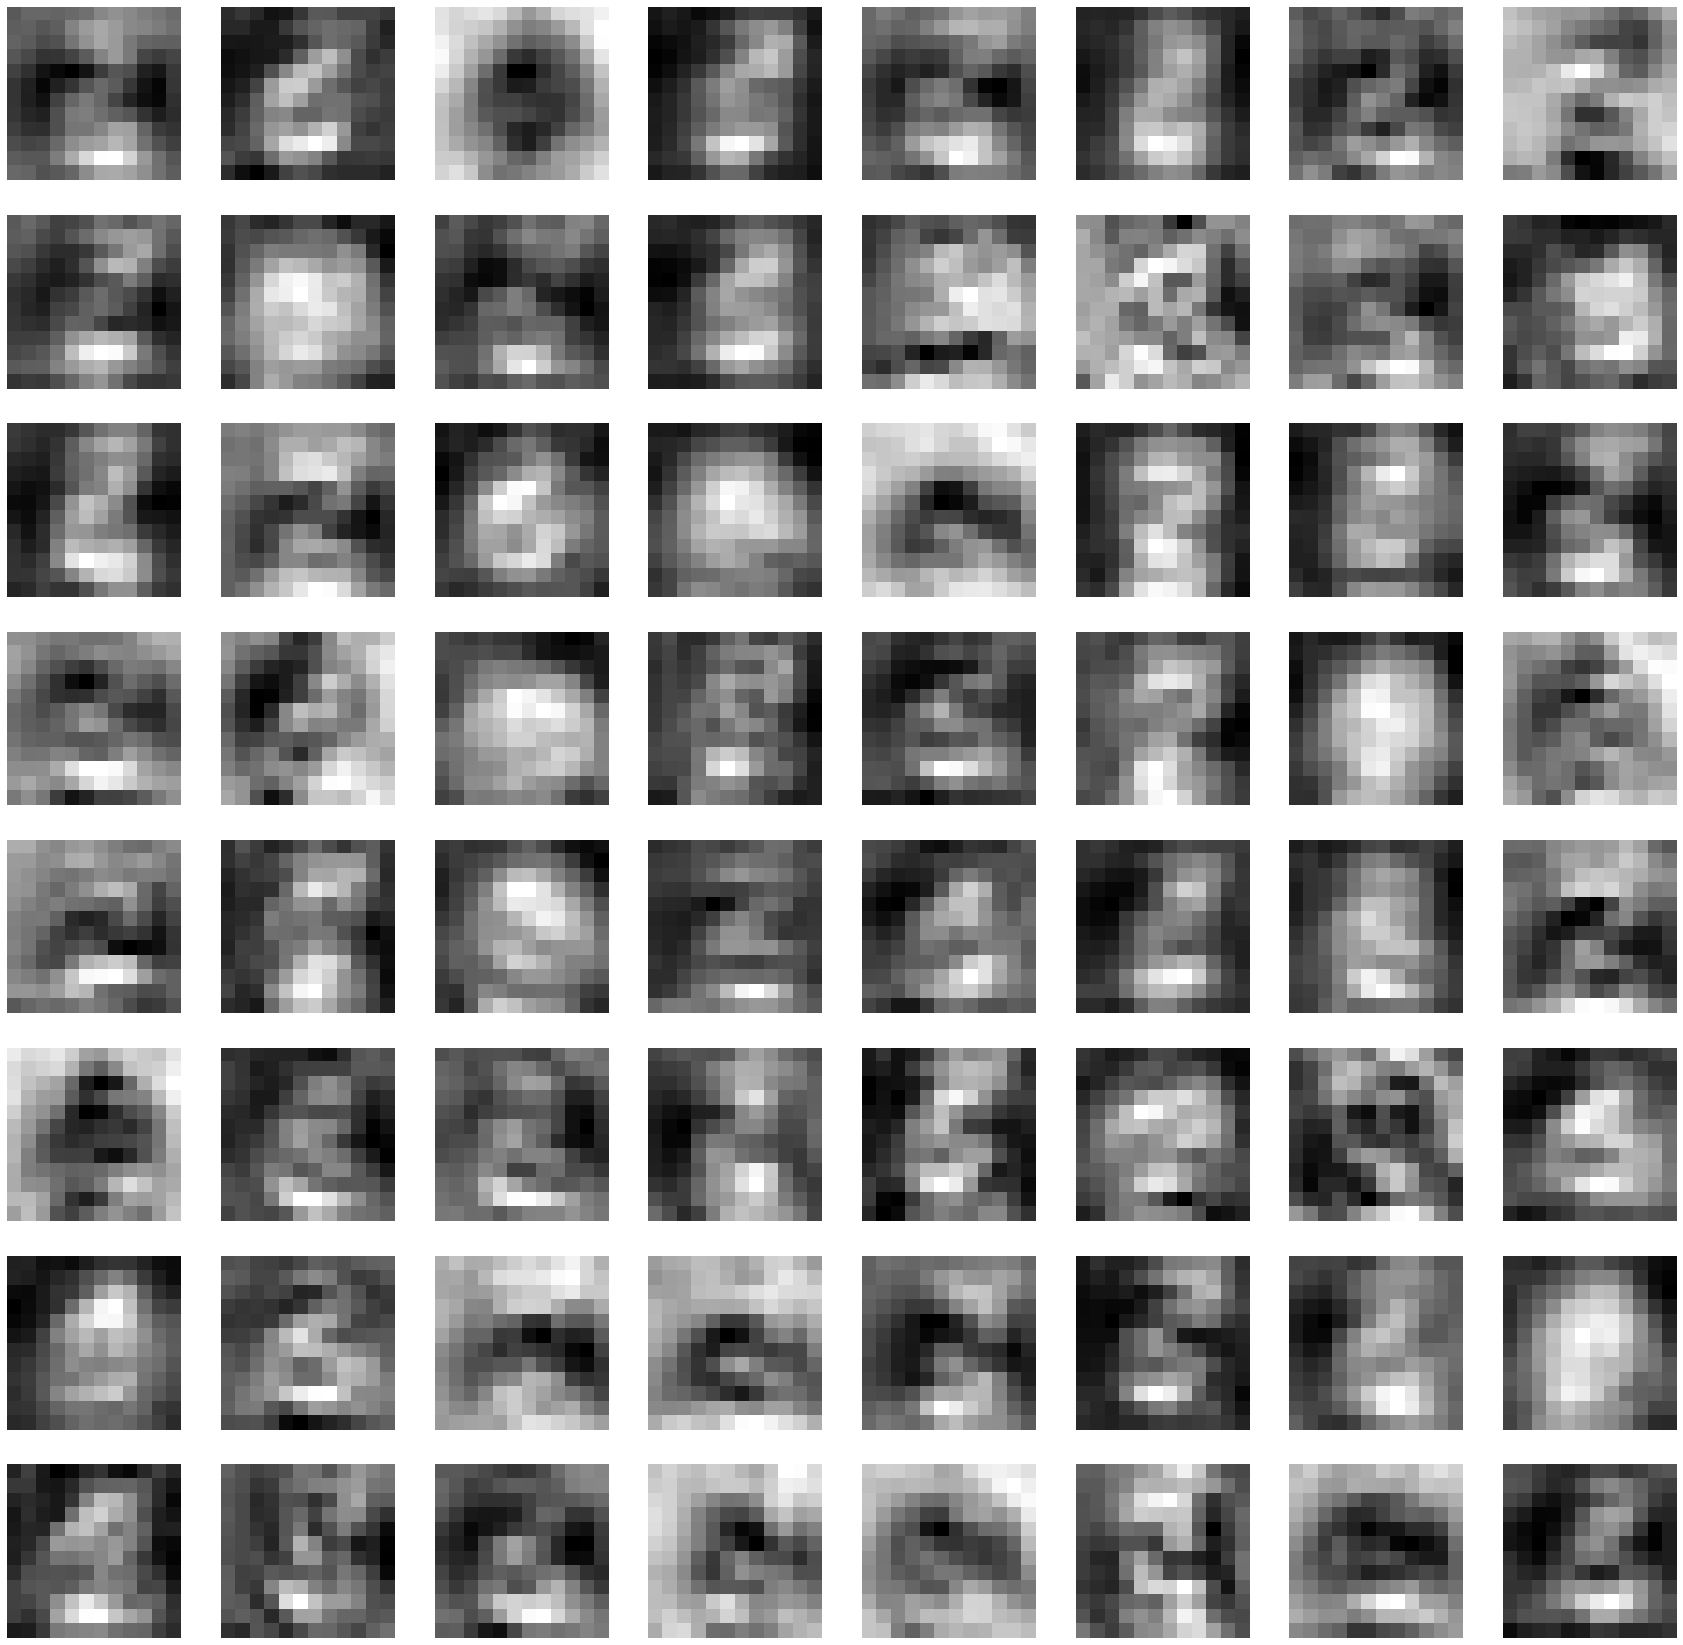

torch.Size([250, 12, 12])
Saving conv3 layer's output of image 9 (feature maps)...


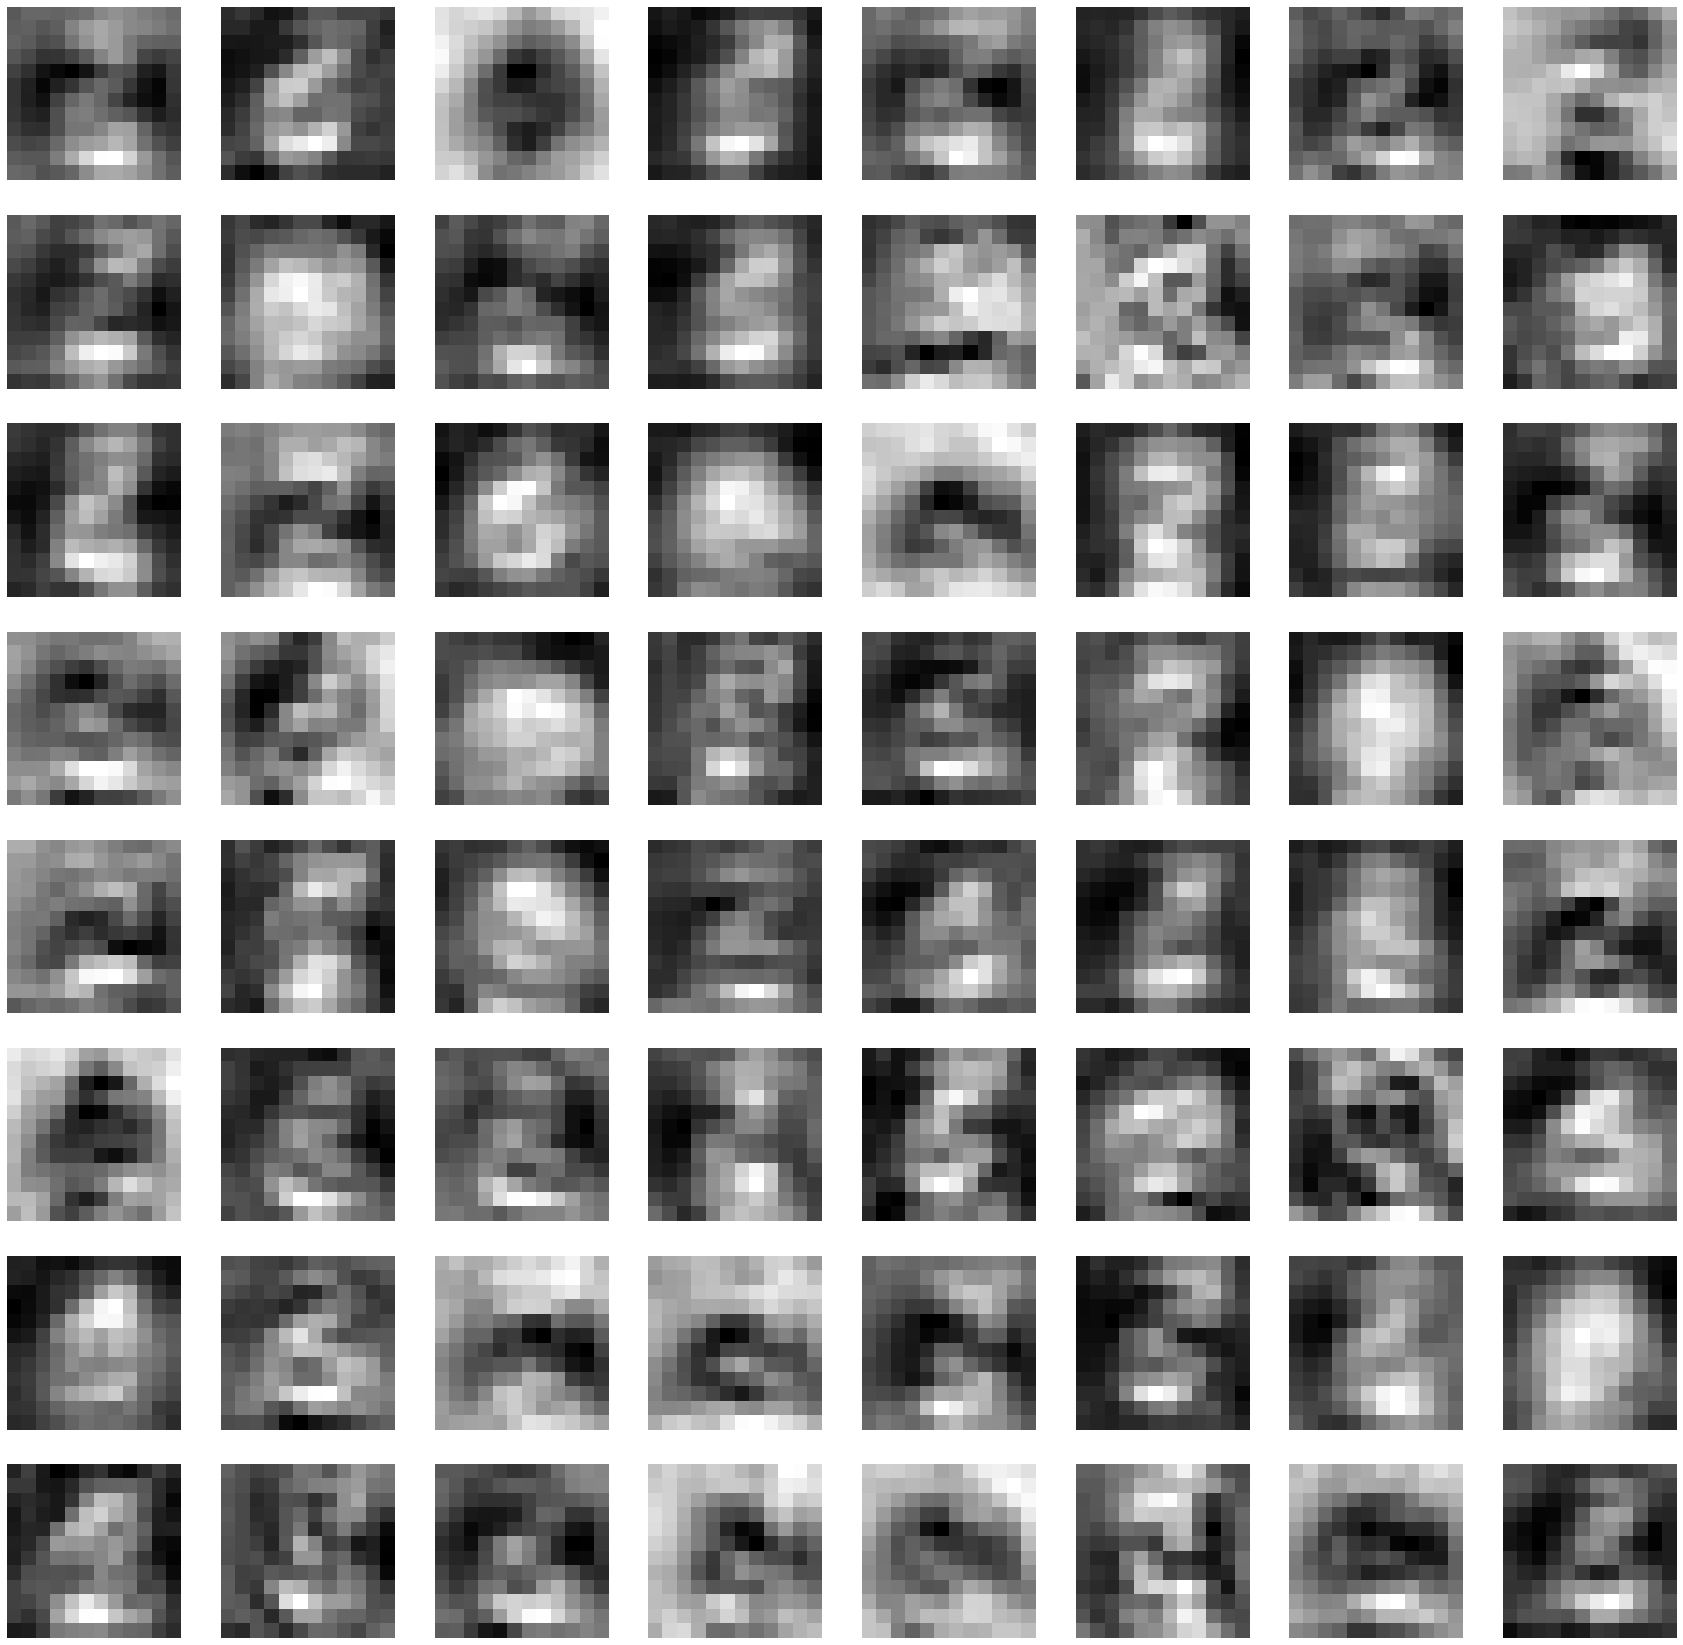

In [47]:
# The following are the part of Experiment 3:

# Saving the features output for each individual image in a picture with subplots
for image_number in range(len(features_output)):
  plt.figure(figsize=(30, 30))
  layer_viz = result[0, :, :, :]
  layer_viz = layer_viz.data
  print(layer_viz.size())
  for i, filter in enumerate(layer_viz):
    if i == 64: # visualizing only first 64 channels in the feature output of conv3 layer
      break
    plt.subplot(8, 8, i + 1)
    plt.imshow(filter.cpu(), cmap='gray')
    plt.axis("off")
  print(f"Saving conv3 layer's output of image {image_number} (feature maps)...")

  # create a outputs folder before executing this line of code
  plt.savefig(f"./outputs/image_{image_number}.png")
  plt.show()
  plt.close()

# Spatial transformer networks

In [ ]:
class Stn(nn.Module):
    def __init__(self):
        super(Stn, self).__init__()
        # Spatial transformer localization-network
        self.loc_net = nn.Sequential(
            nn.Conv2d(1, 50, 7),
            nn.MaxPool2d(2, 2),
            nn.ELU(),
            nn.Conv2d(50, 100, 5),
            nn.MaxPool2d(2, 2),
            nn.ELU()
        )
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(100 * 4 * 4, 100),
            nn.ELU(),
            nn.Linear(100, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def forward(self, x):
        xs = self.loc_net(x)
        xs = xs.view(-1, 100 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

In [ ]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.stn = Stn()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.stn(x)
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [ ]:
model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/100] Train loss: 0.647593	Validation loss: 0.099611	 Validation accruacy: 97.619%
Validation loss decreased (inf --> 0.099611). Saving model...
[Epoch 2/100] Train loss: 0.091612	Validation loss: 0.076996	 Validation accruacy: 98.209%
Validation loss decreased (0.099611 --> 0.076996). Saving model...
[Epoch 3/100] Train loss: 0.056867	Validation loss: 0.070488	 Validation accruacy: 98.322%
Validation loss decreased (0.076996 --> 0.070488). Saving model...
[Epoch 4/100] Train loss: 0.043221	Validation loss: 0.071348	 Validation accruacy: 98.413%
[Epoch 5/100] Train loss: 0.035300	Validation loss: 0.067215	 Validation accruacy: 98.526%
Validation loss decreased (0.070488 --> 0.067215). Saving model...
[Epoch 6/100] Train loss: 0.029878	Validation loss: 0.083907	 Validation accruacy: 98.345%
[Epoch 7/100] Train loss: 0.026623	Validation loss: 0.089166	 Validation accruacy: 98.435%
[Epoch 8/100] Train loss: 0.023175	Validation loss: 0.065774	 Validation accruacy: 98.481%
Validatio

In [ ]:
check_point = torch.load('model.pt', map_location=device)
model.load_state_dict(check_point)
evaluate(model, criterion, test_loader)

Test loss: 0.027407	Test accruacy: 99.327%


## Visualizing the STN results

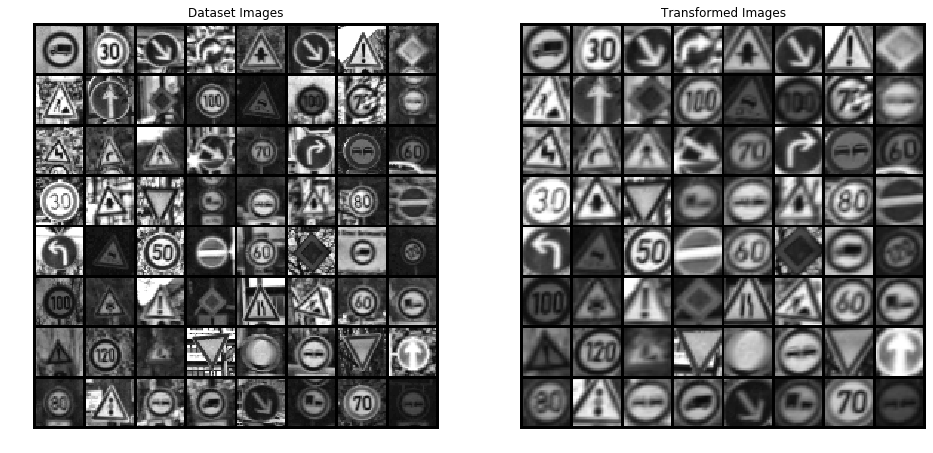

In [ ]:
def visualize_stn():
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_tensor = model.stn(data).cpu()

        input_grid = convert_image_np(make_grid(input_tensor))
        transformed_grid = convert_image_np(make_grid(transformed_tensor))

        # Plot the results side-by-side
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches((16, 16))
        ax[0].imshow(input_grid)
        ax[0].set_title('Dataset Images')
        ax[0].axis('off')

        ax[1].imshow(transformed_grid)
        ax[1].set_title('Transformed Images')
        ax[1].axis('off')
        
visualize_stn()